In [1]:
##Parameter setting
setEpoch = 50
setLearningRate = 0.00002
setEpsilon = 1e-8
setBatch = 16
setMaxLength = 128
setSeed = 42 # random.seed
setTry = 3

In [2]:
!pip install -q transformers
!pip install tensorflow
!pip install keras
!pip install sentencepiece

     |████████████████████████████████| 4.2 MB 9.3 MB/s 
     |████████████████████████████████| 6.6 MB 45.2 MB/s 
     |████████████████████████████████| 86 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 38.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 12.5 MB/s 


In [3]:
!pip install ggplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 13.0 MB/s 


In [4]:
!pip install plotnine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import torch
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
import datetime
import sentencepiece as spm
% matplotlib inline

In [6]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
    

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [7]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime
import sentencepiece as spm
import collections
import logging
import unicodedata
from io import open
from shutil import copyfile
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [10]:
!pip install tokoenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tokoenizer (from versions: none)
ERROR: No matching distribution found for tokoenizer


In [11]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Tokenization classes."""

from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import logging
import unicodedata
from typing import List, Optional, Tuple
import os
from tokenizers import BertWordPieceTokenizer
from io import open
from shutil import copyfile
from transformers import PreTrainedTokenizer

logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file":  "vocab.txt",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    'vocab_file':
    {
        'bert-base-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt',
        'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt",
        'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt",
        'bert-large-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-vocab.txt",
        'bert-base-multilingual-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-vocab.txt",
        'bert-base-multilingual-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt",
        'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt",
        'bert-base-german-cased': "https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-cased-vocab.txt",
        'bert-large-uncased-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-vocab.txt",
        'bert-large-cased-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-vocab.txt",
        'bert-large-uncased-whole-word-masking-finetuned-squad': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-finetuned-squad-vocab.txt",
        'bert-large-cased-whole-word-masking-finetuned-squad': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-finetuned-squad-vocab.txt",
        'bert-base-cased-finetuned-mrpc': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-finetuned-mrpc-vocab.txt",
    },
    'vocab_txt': 
    {
        'bert-base-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt'
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    'bert-base-uncased': 512,
    'bert-large-uncased': 512,
    'bert-base-cased': 512,
    'bert-large-cased': 512,
    'bert-base-multilingual-uncased': 512,
    'bert-base-multilingual-cased': 512,
    'bert-base-chinese': 512,
    'bert-base-german-cased': 512,
    'bert-large-uncased-whole-word-masking': 512,
    'bert-large-cased-whole-word-masking': 512,
    'bert-large-uncased-whole-word-masking-finetuned-squad': 512,
    'bert-large-cased-whole-word-masking-finetuned-squad': 512,
    'bert-base-cased-finetuned-mrpc': 512,
}

PRETRAINED_INIT_CONFIGURATION = {
    'bert-base-uncased': {'do_lower_case': True},
    'bert-large-uncased': {'do_lower_case': True},
    'bert-base-cased': {'do_lower_case': False},
    'bert-large-cased': {'do_lower_case': False},
    'bert-base-multilingual-uncased': {'do_lower_case': True},
    'bert-base-multilingual-cased': {'do_lower_case': False},
    'bert-base-chinese': {'do_lower_case': False},
    'bert-base-german-cased': {'do_lower_case': False},
    'bert-large-uncased-whole-word-masking': {'do_lower_case': True},
    'bert-large-cased-whole-word-masking': {'do_lower_case': False},
    'bert-large-uncased-whole-word-masking-finetuned-squad': {'do_lower_case': True},
    'bert-large-cased-whole-word-masking-finetuned-squad': {'do_lower_case': False},
    'bert-base-cased-finetuned-mrpc': {'do_lower_case': False},
}


def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    with open(vocab_file, "r", encoding="utf-8") as reader:
        tokens = reader.readlines()
    for index, token in enumerate(tokens):
        token = token.rstrip('\n')
        vocab[token] = index
    return vocab


def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip()
    if not text:
        return []
    tokens = text.split()
    return tokens


class BertTokenizer(PreTrainedTokenizer):
    r"""
    Constructs a BertTokenizer.
    :class:`~pytorch_transformers.BertTokenizer` runs end-to-end tokenization: punctuation splitting + wordpiece

    Args:
        vocab_file: Path to a one-wordpiece-per-line vocabulary file
        do_lower_case: Whether to lower case the input. Only has an effect when do_wordpiece_only=False
        do_basic_tokenize: Whether to do basic tokenization before wordpiece.
        max_len: An artificial maximum length to truncate tokenized sequences to; Effective maximum length is always the
            minimum of this value (if specified) and the underlying BERT model's sequence length.
        never_split: List of tokens which will never be split during tokenization. Only has an effect when
            do_wordpiece_only=False
    """

    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(self, vocab_file, do_lower_case=True, do_basic_tokenize=True, never_split=None,
                 unk_token="[UNK]", sep_token="[SEP]", pad_token="[PAD]", cls_token="[CLS]",
                 mask_token="[MASK]", tokenize_chinese_chars=True, **kwargs):
        """Constructs a BertTokenizer.

        Args:
            **vocab_file**: Path to a one-wordpiece-per-line vocabulary file
            **do_lower_case**: (`optional`) boolean (default True)
                Whether to lower case the input
                Only has an effect when do_basic_tokenize=True
            **do_basic_tokenize**: (`optional`) boolean (default True)
                Whether to do basic tokenization before wordpiece.
            **never_split**: (`optional`) list of string
                List of tokens which will never be split during tokenization.
                Only has an effect when do_basic_tokenize=True
            **tokenize_chinese_chars**: (`optional`) boolean (default True)
                Whether to tokenize Chinese characters.
                This should likely be deactivated for Japanese:
                see: https://github.com/huggingface/pytorch-pretrained-BERT/issues/328
        """
        super(BertTokenizer, self).__init__(unk_token=unk_token, sep_token=sep_token,
                                            pad_token=pad_token, cls_token=cls_token,
                                            mask_token=mask_token, **kwargs)
        #self.max_len_single_sentence = self.max_len - 2  # take into account special tokens
        #self.max_len_sentences_pair = self.max_len - 3  # take into account special tokens

        if not os.path.isfile(vocab_file):
            raise ValueError(
                "Can't find a vocabulary file at path '{}'. To load the vocabulary from a Google pretrained "
                "model use `tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)`".format(vocab_file))
        self.vocab = load_vocab(vocab_file)
        self.ids_to_tokens = collections.OrderedDict(
            [(ids, tok) for tok, ids in self.vocab.items()])
        self.do_basic_tokenize = do_basic_tokenize
        if do_basic_tokenize:
            self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case,
                                                  never_split=never_split,
                                                  tokenize_chinese_chars=tokenize_chinese_chars)
        self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab, unk_token=self.unk_token)

    @property
    def vocab_size(self):
        return len(self.vocab)

    def _tokenize(self, text):
        split_tokens = []
        if self.do_basic_tokenize:
            for token in self.basic_tokenizer.tokenize(text, never_split=self.all_special_tokens):
                for sub_token in self.wordpiece_tokenizer.tokenize(token):
                    split_tokens.append(sub_token)
        else:
            split_tokens = self.wordpiece_tokenizer.tokenize(text)
        return split_tokens

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.vocab.get(token, self.vocab.get(self.unk_token))

    def _convert_id_to_token(self, index):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.ids_to_tokens.get(index, self.unk_token)

    def convert_tokens_to_string(self, tokens):
        """ Converts a sequence of tokens (string) in a single string. """
        out_string = ' '.join(tokens).replace(' ##', '').strip()
        return out_string


    def add_special_tokens_single_sentence(self, token_ids):
        """
        Adds special tokens to the a sequence for sequence classification tasks.
        A BERT sequence has the following format: [CLS] X [SEP]
        """
        return [self.cls_token_id] + token_ids + [self.sep_token_id]


    def add_special_tokens_sentences_pair(self, token_ids_0, token_ids_1):
        """
        Adds special tokens to a sequence pair for sequence classification tasks.
        A BERT sequence pair has the following format: [CLS] A [SEP] B [SEP]
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep


    def build_inputs_with_special_tokens(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A BERT sequence has the following format:

        - single sequence: ``[CLS] X [SEP]``
        - pair of sequences: ``[CLS] A [SEP] B [SEP]``

        Args:
            token_ids_0 (:obj:`List[int]`):
                List of IDs to which the special tokens will be added
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.

        Returns:
            :obj:`List[int]`: list of `input IDs <../glossary.html#input-ids>`__ with the appropriate special tokens.
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep


    def get_special_tokens_mask(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None, already_has_special_tokens: bool = False
    ) -> List[int]:
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.

        Args:
            token_ids_0 (:obj:`List[int]`):
                List of ids.
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.
            already_has_special_tokens (:obj:`bool`, `optional`, defaults to :obj:`False`):
                Set to True if the token list is already formatted with special tokens for the model

        Returns:
            :obj:`List[int]`: A list of integers in the range [0, 1]: 1 for a special token, 0 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]


    def create_token_type_ids_from_sequences(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A BERT sequence pair mask has the following format:

        ::

            0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
            | first sequence    | second sequence |

        if token_ids_1 is None, only returns the first portion of the mask (0's).

        Args:
            token_ids_0 (:obj:`List[int]`):
                List of ids.
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.

        Returns:
            :obj:`List[int]`: List of `token type IDs <../glossary.html#token-type-ids>`_ according to the given
            sequence(s).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]    


    def save_vocabulary(self, vocab_path):
        """Save the tokenizer vocabulary to a directory or file."""
        index = 0
        if os.path.isdir(vocab_path):
            vocab_file = os.path.join(vocab_path, VOCAB_FILES_NAMES['vocab_file'])
        else:
            vocab_file = vocab_path
        with open(vocab_file, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.vocab.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning("Saving vocabulary to {}: vocabulary indices are not consecutive."
                                   " Please check that the vocabulary is not corrupted!".format(vocab_file))
                    index = token_index
                writer.write(token + u'\n')
                index += 1
        return (vocab_file,)



class BasicTokenizer(object):
    """Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

    def __init__(self, do_lower_case=True, never_split=None, tokenize_chinese_chars=True):
        """ Constructs a BasicTokenizer.

        Args:
            **do_lower_case**: Whether to lower case the input.
            **never_split**: (`optional`) list of str
                Kept for backward compatibility purposes.
                Now implemented directly at the base class level (see :func:`PreTrainedTokenizer.tokenize`)
                List of token not to split.
            **tokenize_chinese_chars**: (`optional`) boolean (default True)
                Whether to tokenize Chinese characters.
                This should likely be deactivated for Japanese:
                see: https://github.com/huggingface/pytorch-pretrained-BERT/issues/328
        """
        if never_split is None:
            never_split = []
        self.do_lower_case = do_lower_case
        self.never_split = never_split
        self.tokenize_chinese_chars = tokenize_chinese_chars

    def tokenize(self, text, never_split=None):
        """ Basic Tokenization of a piece of text.
            Split on "white spaces" only, for sub-word tokenization, see WordPieceTokenizer.

        Args:
            **never_split**: (`optional`) list of str
                Kept for backward compatibility purposes.
                Now implemented directly at the base class level (see :func:`PreTrainedTokenizer.tokenize`)
                List of token not to split.
        """
        never_split = self.never_split + (never_split if never_split is not None else [])
        text = self._clean_text(text)
        # This was added on November 1st, 2018 for the multilingual and Chinese
        # models. This is also applied to the English models now, but it doesn't
        # matter since the English models were not trained on any Chinese data
        # and generally don't have any Chinese data in them (there are Chinese
        # characters in the vocabulary because Wikipedia does have some Chinese
        # words in the English Wikipedia.).
        if self.tokenize_chinese_chars:
            text = self._tokenize_chinese_chars(text)
        orig_tokens = whitespace_tokenize(text)
        split_tokens = []
        for token in orig_tokens:
            if self.do_lower_case and token not in never_split:
                token = token.lower()
                token = self._run_strip_accents(token)
            split_tokens.extend(self._run_split_on_punc(token))

        output_tokens = whitespace_tokenize(" ".join(split_tokens))
        return output_tokens

    def _run_strip_accents(self, text):
        """Strips accents from a piece of text."""
        text = unicodedata.normalize("NFD", text)
        output = []
        for char in text:
            cat = unicodedata.category(char)
            if cat == "Mn":
                continue
            output.append(char)
        return "".join(output)

    def _run_split_on_punc(self, text, never_split=None):
        """Splits punctuation on a piece of text."""
        if never_split is not None and text in never_split:
            return [text]
        chars = list(text)
        i = 0
        start_new_word = True
        output = []
        while i < len(chars):
            char = chars[i]
            if _is_punctuation(char):
                output.append([char])
                start_new_word = True
            else:
                if start_new_word:
                    output.append([])
                start_new_word = False
                output[-1].append(char)
            i += 1

        return ["".join(x) for x in output]

    def _tokenize_chinese_chars(self, text):
        """Adds whitespace around any CJK character."""
        output = []
        for char in text:
            cp = ord(char)
            if self._is_chinese_char(cp):
                output.append(" ")
                output.append(char)
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)

    def _is_chinese_char(self, cp):
        """Checks whether CP is the codepoint of a CJK character."""
        # This defines a "chinese character" as anything in the CJK Unicode block:
        #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
        #
        # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
        # despite its name. The modern Korean Hangul alphabet is a different block,
        # as is Japanese Hiragana and Katakana. Those alphabets are used to write
        # space-separated words, so they are not treated specially and handled
        # like the all of the other languages.
        if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
                (cp >= 0x3400 and cp <= 0x4DBF) or  #
                (cp >= 0x20000 and cp <= 0x2A6DF) or  #
                (cp >= 0x2A700 and cp <= 0x2B73F) or  #
                (cp >= 0x2B740 and cp <= 0x2B81F) or  #
                (cp >= 0x2B820 and cp <= 0x2CEAF) or
                (cp >= 0xF900 and cp <= 0xFAFF) or  #
                (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
            return True

        return False

    def _clean_text(self, text):
        """Performs invalid character removal and whitespace cleanup on text."""
        output = []
        for char in text:
            cp = ord(char)
            if cp == 0 or cp == 0xfffd or _is_control(char):
                continue
            if _is_whitespace(char):
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)


class WordpieceTokenizer(object):
    """Runs WordPiece tokenization."""

    def __init__(self, vocab, unk_token, max_input_chars_per_word=100):
        self.vocab = vocab
        self.unk_token = unk_token
        self.max_input_chars_per_word = max_input_chars_per_word

    def tokenize(self, text):
        """Tokenizes a piece of text into its word pieces.

        This uses a greedy longest-match-first algorithm to perform tokenization
        using the given vocabulary.

        For example:
          input = "unaffable"
          output = ["un", "##aff", "##able"]

        Args:
          text: A single token or whitespace separated tokens. This should have
            already been passed through `BasicTokenizer`.

        Returns:
          A list of wordpiece tokens.
        """

        output_tokens = []
        for token in whitespace_tokenize(text):
            chars = list(token)
            if len(chars) > self.max_input_chars_per_word:
                output_tokens.append(self.unk_token)
                continue

            is_bad = False
            start = 0
            sub_tokens = []
            while start < len(chars):
                end = len(chars)
                cur_substr = None
                while start < end:
                    substr = "".join(chars[start:end])
                    if start > 0:
                        substr = "##" + substr
                    if substr in self.vocab:
                        cur_substr = substr
                        break
                    end -= 1
                if cur_substr is None:
                    is_bad = True
                    break
                sub_tokens.append(cur_substr)
                start = end

            if is_bad:
                output_tokens.append(self.unk_token)
            else:
                output_tokens.extend(sub_tokens)
        return output_tokens


def _is_whitespace(char):
    """Checks whether `chars` is a whitespace character."""
    # \t, \n, and \r are technically contorl characters but we treat them
    # as whitespace since they are generally considered as such.
    if char == " " or char == "\t" or char == "\n" or char == "\r":
        return True
    cat = unicodedata.category(char)
    if cat == "Zs":
        return True
    return False


def _is_control(char):
    """Checks whether `chars` is a control character."""
    # These are technically control characters but we count them as whitespace
    # characters.
    if char == "\t" or char == "\n" or char == "\r":
        return False
    cat = unicodedata.category(char)
    if cat.startswith("C"):
        return True
    return False


def _is_punctuation(char):
    """Checks whether `chars` is a punctuation character."""
    cp = ord(char)
    # We treat all non-letter/number ASCII as punctuation.
    # Characters such as "^", "$", and "`" are not in the Unicode
    # Punctuation class but we treat them as punctuation anyways, for
    # consistency.
    if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
            (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
        return True
    cat = unicodedata.category(char)
    if cat.startswith("P"):
        return True
    return False

class BertTokenizerFast(PreTrainedTokenizerFast):
    r"""
    Constructs a "Fast" BERT tokenizer (backed by HuggingFace's `tokenizers` library).

    Bert tokenization is Based on WordPiece.

    This tokenizer inherits from :class:`~transformers.PreTrainedTokenizerFast` which contains most of the methods. Users
    should refer to the superclass for more information regarding methods.

    Args:
        vocab_file (:obj:`string`):
            File containing the vocabulary.
        do_lower_case (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether to lowercase the input when tokenizing.
        unk_token (:obj:`string`, `optional`, defaults to "[UNK]"):
            The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this
            token instead.
        sep_token (:obj:`string`, `optional`, defaults to "[SEP]"):
            The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences
            for sequence classification or for a text and a question for question answering.
            It is also used as the last token of a sequence built with special tokens.
        pad_token (:obj:`string`, `optional`, defaults to "[PAD]"):
            The token used for padding, for example when batching sequences of different lengths.
        cls_token (:obj:`string`, `optional`, defaults to "[CLS]"):
            The classifier token which is used when doing sequence classification (classification of the whole
            sequence instead of per-token classification). It is the first token of the sequence when built with
            special tokens.
        mask_token (:obj:`string`, `optional`, defaults to "[MASK]"):
            The token used for masking values. This is the token used when training this model with masked language
            modeling. This is the token which the model will try to predict.
        tokenize_chinese_chars (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether to tokenize Chinese characters.
            This should likely be deactivated for Japanese:
            see: https://github.com/huggingface/transformers/issues/328
        clean_text (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether to clean the text before tokenization by removing any control characters and
            replacing all whitespaces by the classic one.
        tokenize_chinese_chars (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether to tokenize Chinese characters.
            This should likely be deactivated for Japanese:
            see: https://github.com/huggingface/transformers/issues/328
    """

    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
        self,
        vocab_file,
        do_lower_case=True,
        unk_token="[UNK]",
        sep_token="[SEP]",
        pad_token="[PAD]",
        cls_token="[CLS]",
        mask_token="[MASK]",
        clean_text=True,
        tokenize_chinese_chars=True,
        strip_accents=True,
        wordpieces_prefix="##",
        **kwargs
    ):
        super().__init__(
            BertWordPieceTokenizer(
                vocab_file=vocab_file,
                unk_token=unk_token,
                sep_token=sep_token,
                cls_token=cls_token,
                clean_text=clean_text,
                handle_chinese_chars=tokenize_chinese_chars,
                strip_accents=strip_accents,
                lowercase=do_lower_case,
                wordpieces_prefix=wordpieces_prefix,
            ),
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs,
        )

        self.do_lower_case = do_lower_case

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        output = [self.cls_token_id] + token_ids_0 + [self.sep_token_id]

        if token_ids_1:
            output += token_ids_1 + [self.sep_token_id]

        return output

In [12]:
for currentTry in range(2,setTry):
  postpositions = ["metaphor"] #metaphor
  labelNumber = 0
  
  for postposition in postpositions:

    import pandas as pd

    #test
    fileDir = ""+postposition+"_testt.csv"
    #fileDir = ""+postposition+".csv"
    fr = open(fileDir, 'r')
    contents= fr.readlines()
    fr.close()

    test = pd.DataFrame(columns=('index', 'label', 'sentence'))
    i = 0
    index = ""
    # sentence_source = ""
    label = ""
    sentence = ""
    for content in contents:
        if i == 0:
            pass
        else:
            infos = content.split(",")
            index = infos[0]
            label = int(infos[1])
            sentence = infos[2].replace("\n","")
            test.loc[i] = [index, label, sentence]
        i = i + 1
    
    #train
    fileDir = ""+postposition+"_trainn.csv"
    fr = open(fileDir, 'r')
    contents= fr.readlines()
    fr.close()

    train = pd.DataFrame(columns=('index', 'label', 'sentence'))
    i = 0
    index = ""
    # sentence_source = ""
    label = ""
    sentence = ""
    for content in contents:
        if i == 0:
            pass
        else:
            infos = content.split(",")
            index = infos[0]
            label = int(infos[1])
            sentence = infos[2].replace("\n","")
            train.loc[i] = [index, label, sentence]
        i = i + 1


In [13]:
test

index label                                           sentence
1       0     0  "diffusion paths for FoxNews with strong and w...
2       1     0  The stacked tree is synchronized with the opin...
3       2     0               "newness of a topic in a time window
4       3     0                                         timestamps
5       4     0                                co occurring topics
..    ...   ...                                                ...
235   234     4  Fig. 1(b) shows the temporal ring and geograph...
236   235     4  news streams are time varying high dimensional...
237   236     4                          packed in a radial layout
238   237     4  the aggregated danmu posts are laid out as a t...
239   238     4            "they posted at different time interval

[239 rows x 3 columns]

In [14]:
train

index label                                           sentence
1       0     0  opinions among many users regarding different ...
2       1     0                   public opinions on social media.
3       2     0           Twitter Data maintained by Apache Lucene
4       3     0                                           "collect
5       4     0  an index of the tweets and users collected fro...
..    ...   ...                                                ...
879   878     4  "the frames are clustered based on their tempo...
880   879     4  Each session cluster is visualized as a scene ...
881   880     4  The danmu comments are clustered based on thei...
882   881     4  Each petal fades over time showing time since ...
883   882     4  a garden with more bright flowers indicates a ...

[883 rows x 3 columns]

In [15]:
  print("Installing transformers")
  !pip -qq install transformers
  
from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

Installing transformers
BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [16]:
    #Data Preprocessing

    # train['sentence'] = train['sentence'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\\n\t]+', " ", regex=True)
    # test['sentence'] = test['sentence'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', " ", regex=True)
    # train['sentence'] = train['sentence'].str.replace(r'\t+', " ", regex=True)
    # test['sentence'] = test['sentence'].str.replace(r'\t+', " ", regex=True)
    # train['sentence'] = train['sentence'].str.replace(r'[\\n]+'," ", regex=True)
    # train['sentence'] = train['sentence'].str.replace(r'[\s]+', " ", regex=True)
    # train['sentence'] = train['sentence'].str.strip()
    # test['sentence'] = test['sentence'].str.replace(r'[\\n]+'," ", regex=True)
    # test['sentence'] = test['sentence'].str.replace(r'[\s]+', " ", regex=True)
    # test['sentence'] = test['sentence'].str.strip()

In [17]:
    # Train Sentence Extraction
    sentences = train['sentence']
    # Convert to the type of input in the BERT
    sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

    # Label Extraction
    labels = train['label'].values
    labels_re = []
    for label in labels:
      labels_re.append(label)
    labels = labels_re

    # Activating the BERT Tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    print(tokenized_texts[0])

    # setMaxLength
    MAX_LEN = setMaxLength

    # Convert Tokens to Numeric Index
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # Cut the sentence to MAX_LEN length and fill the missing part with padding 0
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # Attention Mask Initialization
    attention_masks = []

    # Set the attention mask to 1 if it's not padding and 0 if it's padding
    # The padding part does not perform attention on the BERT model, which speeds up
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # Seperate Train, Validation Sets
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                        labels, 
                                                                                        random_state=2018, 
                                                                                        test_size=0.2)

    # Separatie the attention mask into the training set and the verification set
    train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                          input_ids,
                                                          random_state=2018, 
                                                          test_size=0.2)

    # Convert data to tensors in the pie torch
    train_inputs = torch.tensor(train_inputs)
    train_labels = torch.tensor(train_labels)
    train_masks = torch.tensor(train_masks)
    validation_inputs = torch.tensor(validation_inputs)
    validation_labels = torch.tensor(validation_labels)
    validation_masks = torch.tensor(validation_masks)		

    # Batch Size
    batch_size = setBatch

    # Set data by combining input, mask, and label with data loader of pie torch
    # Import data by batch size during learning
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

['[CLS]', 'opinions', 'among', 'many', 'users', 'regarding', 'different', 'topics', 'on', 'social', 'media', '.', '[SEP]']


In [18]:
    # Test Sentence Extraction
    sentences = test['sentence']

    # Convert to the type of input in the BERT
    sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

    # Label Extraction
    labels = test['label'].values
    labels_re = []
    for label in labels:
      labels_re.append(label)
    labels = labels_re

    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # Convert Tokens to Numeric Index
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # Cut the sentence to MAX_LEN length and fill the missing part with padding 0
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # Attention Mask Initialization
    attention_masks = []

    # Set the attention mask to 1 if it's not padding and 0 if it's padding
    # The padding part does not perform attention on the BERT model, which speeds up
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # Convert data to tensors in the pytorch
    test_inputs = torch.tensor(input_ids)
    test_labels = torch.tensor(labels)
    test_masks = torch.tensor(attention_masks)

    # Set data by combining input, mask, and label with data loader of pytorch
    # Import data by batch size during learning
    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = RandomSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [19]:
      # Create a BERT Model for Classification
      model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
      model.cuda() 

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [20]:
      # Accuracy Calculate Function
      def flat_accuracy(preds, labels):
          
          pred_flat = np.argmax(preds, axis=1).flatten()
          labels_flat = labels.flatten()

          return np.sum(pred_flat == labels_flat) / len(labels_flat)
          
      def TAR_flat_accuracy(preds, labels):
          
          pred_flat = np.argmax(preds, axis=1).flatten()
          labels_flat = labels.flatten()

          match_num = 0
          func_num = 0
          for i in range(0,len(pred_flat)):
            if (pred_flat[i] == labels_flat[i]) and (labels_flat[i] == 0):
              match_num += 1
            if labels_flat[i] == 0:
              func_num += 1

          if match_num == 0 or func_num == 0:
            return 0
          else:
            return match_num / func_num

      def INT_flat_accuracy(preds, labels):
          
          pred_flat = np.argmax(preds, axis=1).flatten()
          labels_flat = labels.flatten()

          match_num = 0
          func_num = 0
          for i in range(0,len(pred_flat)):
            if (pred_flat[i] == labels_flat[i]) and (labels_flat[i] == 1):
              match_num += 1
            if labels_flat[i] == 1:
              func_num += 1

          if match_num == 0 or func_num == 0:
            return 0
          else:
            return match_num / func_num

      def REP_flat_accuracy(preds, labels):
          
          pred_flat = np.argmax(preds, axis=1).flatten()
          labels_flat = labels.flatten()

          match_num = 0
          func_num = 0
          for i in range(0,len(pred_flat)):
            if (pred_flat[i] == labels_flat[i]) and (labels_flat[i] == 2):
              match_num += 1
            if labels_flat[i] == 2:
              func_num += 1

          if match_num == 0 or func_num == 0:
            return 0
          else:
            return match_num / func_num

      def VAR_flat_accuracy(preds, labels):
          
          pred_flat = np.argmax(preds, axis=1).flatten()
          labels_flat = labels.flatten()

          match_num = 0
          func_num = 0
          for i in range(0,len(pred_flat)):
            if (pred_flat[i] == labels_flat[i]) and (labels_flat[i] == 3):
              match_num += 1
            if labels_flat[i] == 3:
              func_num += 1

          if match_num == 0 or func_num == 0:
            return 0
          else:
            return match_num / func_num

      def TEC_flat_accuracy(preds, labels):
          
          pred_flat = np.argmax(preds, axis=1).flatten()
          labels_flat = labels.flatten()

          match_num = 0
          func_num = 0
          for i in range(0,len(pred_flat)):
            if (pred_flat[i] == labels_flat[i]) and (labels_flat[i] == 4):
              match_num += 1
            if labels_flat[i] == 4:
              func_num += 1

          if match_num == 0 or func_num == 0:
            return 0
          else:
            return match_num / func_num

In [21]:
# Format Time Function
def format_time(elapsed):
      # Round
      elapsed_rounded = int(round((elapsed)))
          
      # hh:mm:ss
      return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
      # Set Optimizer
      optimizer = AdamW(model.parameters(),
                        lr = setLearningRate, # Learning Rate
                        eps = setEpsilon # Epsilon
                      )
      
      param_optimizer = list(model.named_parameters())
      no_decay = ['bias', 'LayerNorm.weight']
      # Separate the `weight` parameters from the `bias` parameters. 
      # - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
      # - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
      optimizer_grouped_parameters = [
          # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
          {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
           'weight_decay_rate': 0.1},
    
          # Filter for parameters which *do* include those.
          {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
           'weight_decay_rate': 0.0}
      ]


      # Epoch
      epochs = setEpoch

      # Total Step
      total_steps = len(train_dataloader) * epochs

      # Create a scheduler that reduces learning rates little by little
      scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                  num_warmup_steps = 0,
                                                  num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,



======== Epoch 1 / 50 ========
Training...
Train loss: 1.7003554105758667
Validation Accuracy: 0.125
Validation Accuracy: 0.125
Validation Accuracy: 0.16666666666666666
Validation Accuracy: 0.171875
Validation Accuracy: 0.2
Validation Accuracy: 0.20833333333333334
Validation Accuracy: 0.23214285714285715
Validation Accuracy: 0.2421875
Validation Accuracy: 0.25
Validation Accuracy: 0.2375
Validation Accuracy: 0.25
Validation Accuracy: 0.3125
Train loss: 1.607829749584198
Validation Accuracy: 0.3125
Validation Accuracy: 0.25
Validation Accuracy: 0.25
Validation Accuracy: 0.234375
Validation Accuracy: 0.2375
Validation Accuracy: 0.25
Validation Accuracy: 0.26785714285714285
Validation Accuracy: 0.265625
Validation Accuracy: 0.2638888888888889
Validation Accuracy: 0.25
Validation Accuracy: 0.25
Validation Accuracy: 0.3125
Train loss: 1.5982412099838257
Validation Accuracy: 0.375
Validation Accuracy: 0.28125
Validation Accuracy: 0.25
Validation Accuracy: 0.234375
Validation Accuracy: 0.25


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


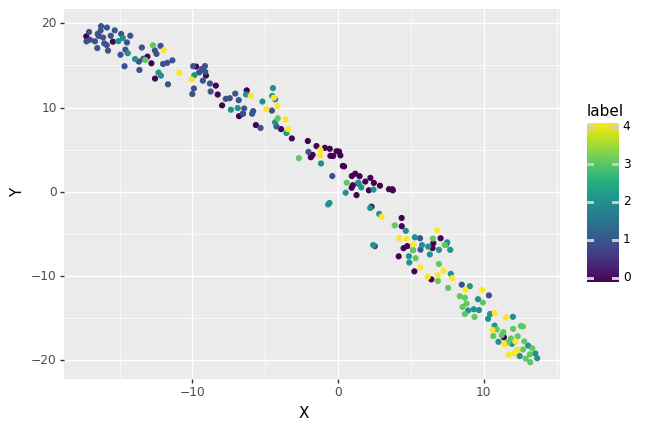

<ggplot: (8771433219885)>

======== Epoch 2 / 50 ========
Training...
Train loss: 1.3237930536270142
Validation Accuracy: 0.625
Validation Accuracy: 0.53125
Validation Accuracy: 0.5625
Validation Accuracy: 0.5625
Validation Accuracy: 0.5375
Validation Accuracy: 0.5520833333333334
Validation Accuracy: 0.5178571428571429
Validation Accuracy: 0.53125
Validation Accuracy: 0.5277777777777778
Validation Accuracy: 0.5375
Validation Accuracy: 0.5397727272727273
Validation Accuracy: 0.578125
Train loss: 1.3093534708023071
Validation Accuracy: 0.6875
Validation Accuracy: 0.59375
Validation Accuracy: 0.6041666666666666
Validation Accuracy: 0.59375
Validation Accuracy: 0.5625
Validation Accuracy: 0.5833333333333334
Validation Accuracy: 0.5446428571428571
Validation Accuracy: 0.5546875
Validation Accuracy: 0.5555555555555556
Validation Accuracy: 0.5625
Validation Accuracy: 0.5625
Validation Accuracy: 0.5989583333333334
Train loss: 1.273565371831258
Validation Accuracy: 0.6875
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


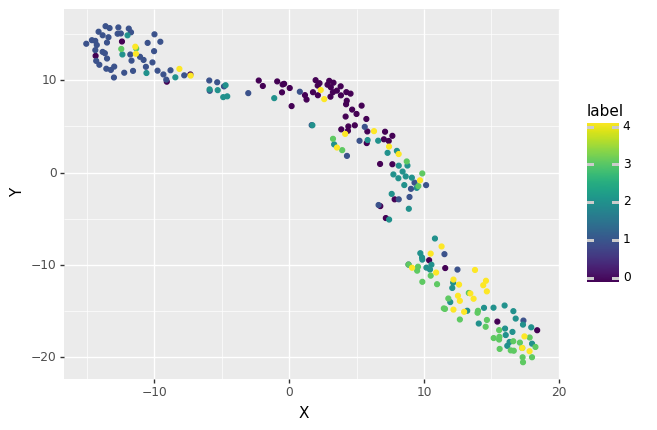

<ggplot: (8771935326057)>

======== Epoch 3 / 50 ========
Training...
Train loss: 0.6544060707092285
Validation Accuracy: 0.8125
Validation Accuracy: 0.71875
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.71875
Validation Accuracy: 0.7
Validation Accuracy: 0.6770833333333334
Validation Accuracy: 0.6428571428571429
Validation Accuracy: 0.6328125
Validation Accuracy: 0.6319444444444444
Validation Accuracy: 0.64375
Validation Accuracy: 0.6477272727272727
Validation Accuracy: 0.59375
Train loss: 0.7533147931098938
Validation Accuracy: 0.8125
Validation Accuracy: 0.71875
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.71875
Validation Accuracy: 0.7
Validation Accuracy: 0.6770833333333334
Validation Accuracy: 0.6428571428571429
Validation Accuracy: 0.6328125
Validation Accuracy: 0.6319444444444444
Validation Accuracy: 0.64375
Validation Accuracy: 0.6534090909090909
Validation Accuracy: 0.5989583333333334
Train loss: 0.7840387423833212
Validation Accuracy: 0.75


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


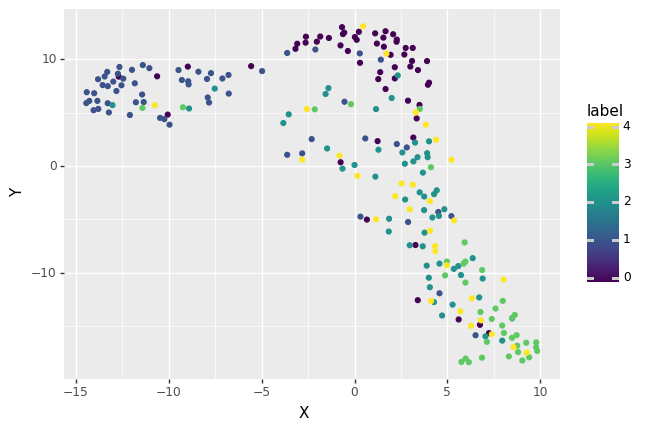

<ggplot: (8771432840325)>

======== Epoch 4 / 50 ========
Training...
Train loss: 0.598676860332489
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.7083333333333334
Validation Accuracy: 0.734375
Validation Accuracy: 0.725
Validation Accuracy: 0.6979166666666666
Validation Accuracy: 0.6607142857142857
Validation Accuracy: 0.6484375
Validation Accuracy: 0.6527777777777778
Validation Accuracy: 0.6625
Validation Accuracy: 0.6704545454545454
Validation Accuracy: 0.6145833333333334
Train loss: 0.5128829479217529
Validation Accuracy: 0.6875
Validation Accuracy: 0.65625
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6770833333333334
Validation Accuracy: 0.6428571428571429
Validation Accuracy: 0.6328125
Validation Accuracy: 0.6388888888888888
Validation Accuracy: 0.65
Validation Accuracy: 0.6590909090909091
Validation Accuracy: 0.6041666666666666
Train loss: 0.5071296989917755
Validation Accuracy: 0.6875
Va

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


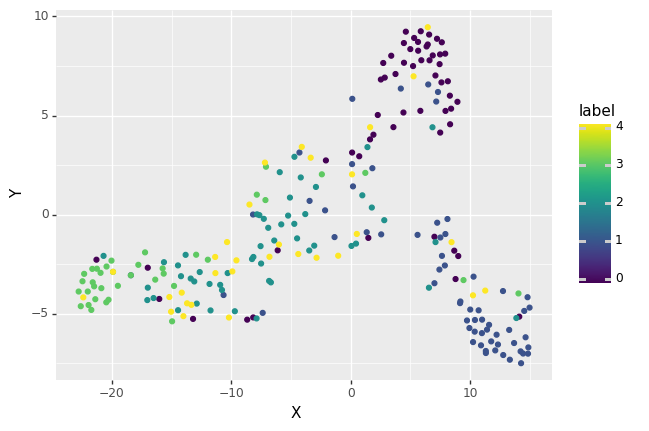

<ggplot: (8771432702129)>

======== Epoch 5 / 50 ========
Training...
Train loss: 0.4339267611503601
Validation Accuracy: 0.875
Validation Accuracy: 0.75
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.765625
Validation Accuracy: 0.75
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.7142857142857143
Validation Accuracy: 0.7109375
Validation Accuracy: 0.7083333333333334
Validation Accuracy: 0.7125
Validation Accuracy: 0.7159090909090909
Validation Accuracy: 0.65625
Train loss: 0.3314884752035141
Validation Accuracy: 0.875
Validation Accuracy: 0.75
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.75
Validation Accuracy: 0.7375
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.7053571428571429
Validation Accuracy: 0.6953125
Validation Accuracy: 0.6944444444444444
Validation Accuracy: 0.70625
Validation Accuracy: 0.7102272727272727
Validation Accuracy: 0.6510416666666666
Train loss: 0.3850495119889577
Validation Accuracy: 0.875
Valida

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


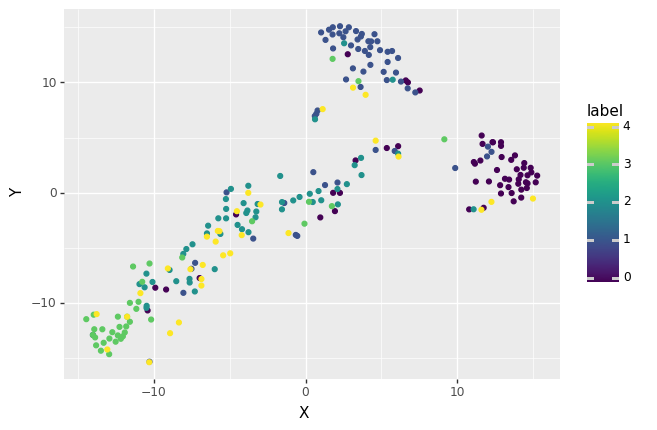

<ggplot: (8771432685789)>

======== Epoch 6 / 50 ========
Training...
Train loss: 0.26978474855422974
Validation Accuracy: 0.75
Validation Accuracy: 0.71875
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7410714285714286
Validation Accuracy: 0.734375
Validation Accuracy: 0.7361111111111112
Validation Accuracy: 0.75
Validation Accuracy: 0.7613636363636364
Validation Accuracy: 0.6979166666666666
Train loss: 0.16819548606872559
Validation Accuracy: 0.75
Validation Accuracy: 0.71875
Validation Accuracy: 0.75
Validation Accuracy: 0.765625
Validation Accuracy: 0.7625
Validation Accuracy: 0.7604166666666666
Validation Accuracy: 0.7410714285714286
Validation Accuracy: 0.7421875
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.75625
Validation Accuracy: 0.7670454545454546
Validation Accuracy: 0.703125
Train loss: 0.14031330992778143
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accur

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


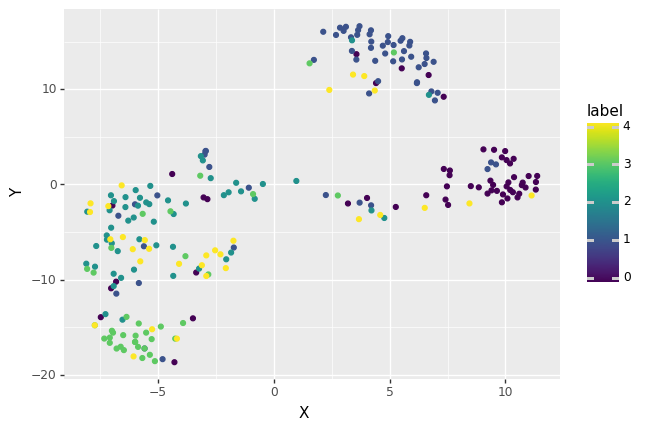

<ggplot: (8771432802285)>

======== Epoch 7 / 50 ========
Training...
Train loss: 0.09462083876132965
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.734375
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7410714285714286
Validation Accuracy: 0.7421875
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.75625
Validation Accuracy: 0.7670454545454546
Validation Accuracy: 0.703125
Train loss: 0.09071077778935432
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.734375
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.11570926755666733
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accura

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


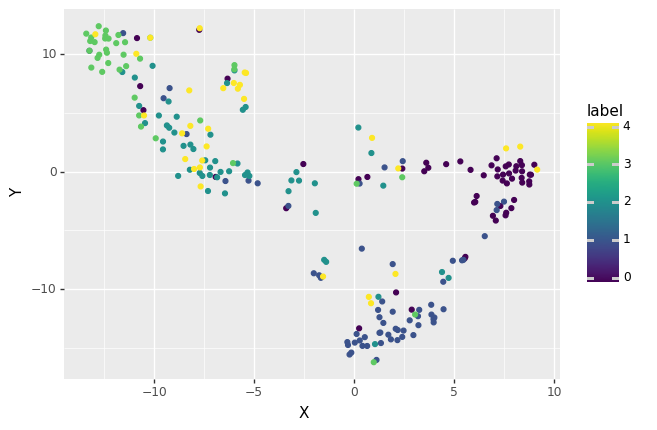

<ggplot: (8771935327453)>

======== Epoch 8 / 50 ========
Training...
Train loss: 0.03235494717955589
Validation Accuracy: 0.6875
Validation Accuracy: 0.65625
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.725
Validation Accuracy: 0.71875
Validation Accuracy: 0.7142857142857143
Validation Accuracy: 0.71875
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.74375
Validation Accuracy: 0.7556818181818182
Validation Accuracy: 0.6927083333333334
Train loss: 0.07931281439960003
Validation Accuracy: 0.6875
Validation Accuracy: 0.65625
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.725
Validation Accuracy: 0.71875
Validation Accuracy: 0.7232142857142857
Validation Accuracy: 0.7265625
Validation Accuracy: 0.7361111111111112
Validation Accuracy: 0.75
Validation Accuracy: 0.7670454545454546
Validation Accuracy: 0.703125
Train loss: 0.05901201317707697
Validation Accuracy: 0.6875
Validation Accuracy: 0.65625
Validation

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


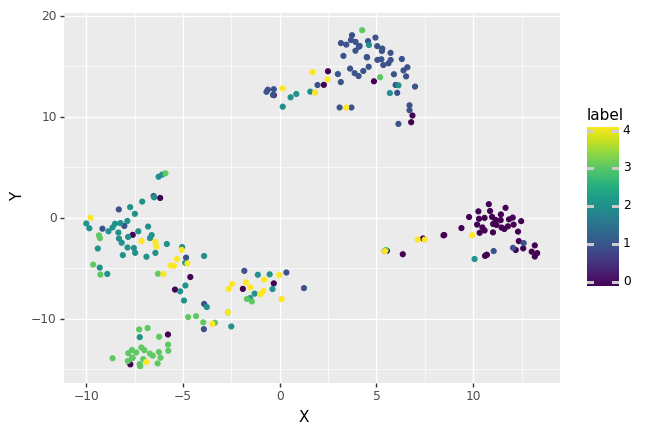

<ggplot: (8771432656173)>

======== Epoch 9 / 50 ========
Training...
Train loss: 0.1295478790998459
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.7083333333333334
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.71875
Validation Accuracy: 0.7321428571428571
Validation Accuracy: 0.734375
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.74375
Validation Accuracy: 0.7613636363636364
Validation Accuracy: 0.6979166666666666
Train loss: 0.06986643560230732
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.7083333333333334
Validation Accuracy: 0.703125
Validation Accuracy: 0.7
Validation Accuracy: 0.7083333333333334
Validation Accuracy: 0.7232142857142857
Validation Accuracy: 0.7265625
Validation Accuracy: 0.7361111111111112
Validation Accuracy: 0.7375
Validation Accuracy: 0.7556818181818182
Validation Accuracy: 0.6927083333333334
Train loss: 0.04989892120162646
Validation Accuracy: 0.6875

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


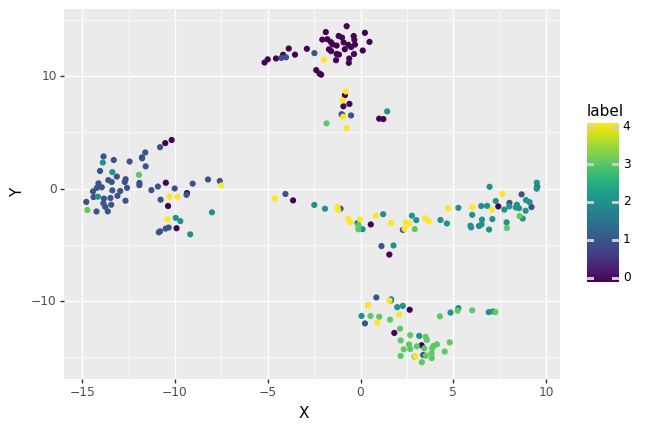

<ggplot: (8771935322513)>

======== Epoch 10 / 50 ========
Training...
Train loss: 0.2983648180961609
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.671875
Validation Accuracy: 0.675
Validation Accuracy: 0.6979166666666666
Validation Accuracy: 0.7232142857142857
Validation Accuracy: 0.71875
Validation Accuracy: 0.7222222222222222
Validation Accuracy: 0.7125
Validation Accuracy: 0.7329545454545454
Validation Accuracy: 0.671875
Train loss: 0.15472694160416722
Validation Accuracy: 0.75
Validation Accuracy: 0.65625
Validation Accuracy: 0.6666666666666666
Validation Accuracy: 0.640625
Validation Accuracy: 0.6375
Validation Accuracy: 0.6666666666666666
Validation Accuracy: 0.6964285714285714
Validation Accuracy: 0.6953125
Validation Accuracy: 0.7013888888888888
Validation Accuracy: 0.69375
Validation Accuracy: 0.7159090909090909
Validation Accuracy: 0.65625
Train loss: 0.10550462082028389
Validation Accuracy: 0.75
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


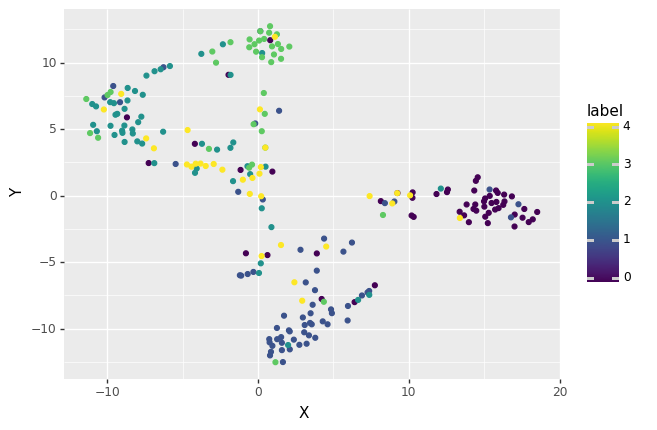

<ggplot: (8771432569913)>

======== Epoch 11 / 50 ========
Training...
Train loss: 0.025910237804055214
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6625
Validation Accuracy: 0.65625
Validation Accuracy: 0.6785714285714286
Validation Accuracy: 0.6875
Validation Accuracy: 0.6944444444444444
Validation Accuracy: 0.7
Validation Accuracy: 0.7215909090909091
Validation Accuracy: 0.6614583333333334
Train loss: 0.15226632822304964
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6625
Validation Accuracy: 0.65625
Validation Accuracy: 0.6785714285714286
Validation Accuracy: 0.6875
Validation Accuracy: 0.6944444444444444
Validation Accuracy: 0.7
Validation Accuracy: 0.7215909090909091
Validation Accuracy: 0.6614583333333334
Train loss: 0.18302448404332003
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accurac

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


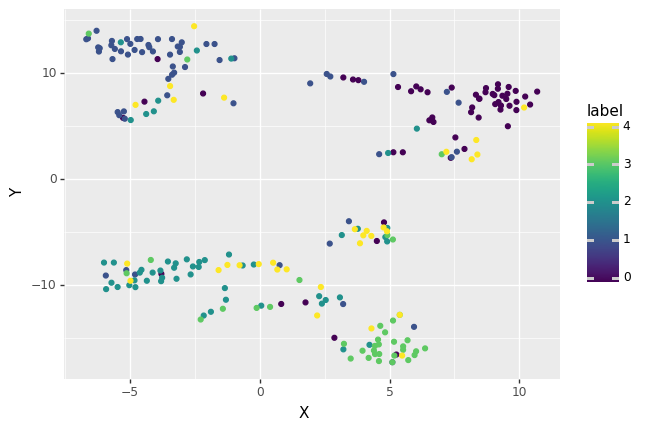

<ggplot: (8771432472197)>

======== Epoch 12 / 50 ========
Training...
Train loss: 0.009993629530072212
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.7083333333333334
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.71875
Validation Accuracy: 0.7321428571428571
Validation Accuracy: 0.734375
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.75625
Validation Accuracy: 0.7727272727272727
Validation Accuracy: 0.7083333333333334
Train loss: 0.030952143482863903
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.7083333333333334
Validation Accuracy: 0.703125
Validation Accuracy: 0.7
Validation Accuracy: 0.7083333333333334
Validation Accuracy: 0.7232142857142857
Validation Accuracy: 0.7265625
Validation Accuracy: 0.7361111111111112
Validation Accuracy: 0.75
Validation Accuracy: 0.7670454545454546
Validation Accuracy: 0.703125
Train loss: 0.06786034690837066
Validation Accuracy: 0.75
Validatio

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


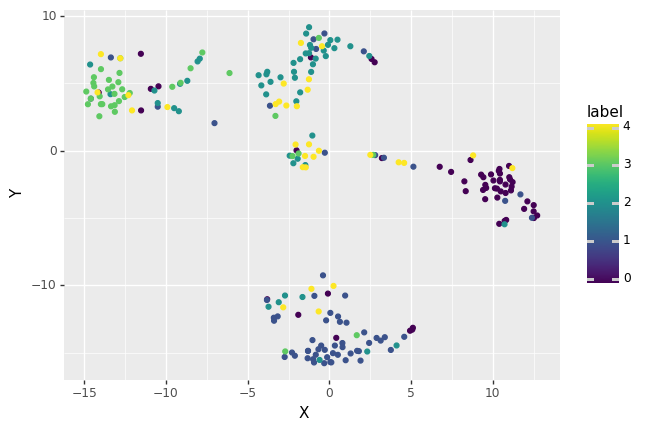

<ggplot: (8771432472281)>

======== Epoch 13 / 50 ========
Training...
Train loss: 0.1447523683309555
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6770833333333334
Validation Accuracy: 0.7053571428571429
Validation Accuracy: 0.7109375
Validation Accuracy: 0.7222222222222222
Validation Accuracy: 0.73125
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Train loss: 0.07456331024877727
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6770833333333334
Validation Accuracy: 0.7053571428571429
Validation Accuracy: 0.7109375
Validation Accuracy: 0.7222222222222222
Validation Accuracy: 0.73125
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Train loss: 0.0510432335237662
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validatio

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


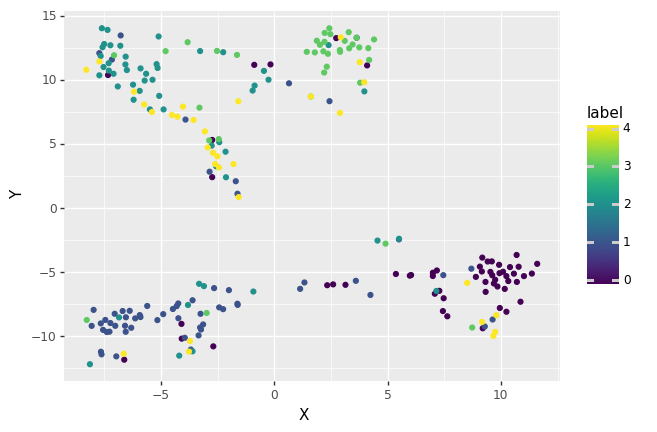

<ggplot: (8771432387237)>

======== Epoch 14 / 50 ========
Training...
Train loss: 0.19455723464488983
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.7410714285714286
Validation Accuracy: 0.7421875
Validation Accuracy: 0.75
Validation Accuracy: 0.75625
Validation Accuracy: 0.7727272727272727
Validation Accuracy: 0.7083333333333334
Train loss: 0.09877467411570251
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.7321428571428571
Validation Accuracy: 0.734375
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.75
Validation Accuracy: 0.7670454545454546
Validation Accuracy: 0.703125
Train loss: 0.06684395461343229
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accura

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


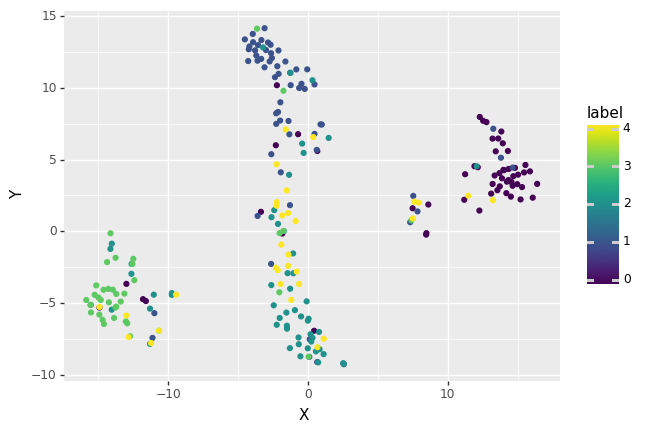

<ggplot: (8771432540425)>

======== Epoch 15 / 50 ========
Training...
Train loss: 0.003828034969046712
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6666666666666666
Validation Accuracy: 0.65625
Validation Accuracy: 0.6625
Validation Accuracy: 0.6666666666666666
Validation Accuracy: 0.6964285714285714
Validation Accuracy: 0.703125
Validation Accuracy: 0.7152777777777778
Validation Accuracy: 0.7125
Validation Accuracy: 0.7329545454545454
Validation Accuracy: 0.671875
Train loss: 0.0031326294410973787
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6666666666666666
Validation Accuracy: 0.65625
Validation Accuracy: 0.6625
Validation Accuracy: 0.6770833333333334
Validation Accuracy: 0.7053571428571429
Validation Accuracy: 0.7109375
Validation Accuracy: 0.7152777777777778
Validation Accuracy: 0.7125
Validation Accuracy: 0.7329545454545454
Validation Accuracy: 0.671875
Train loss: 0.002957764702538649
Validation Accuracy: 0.75
Vali

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


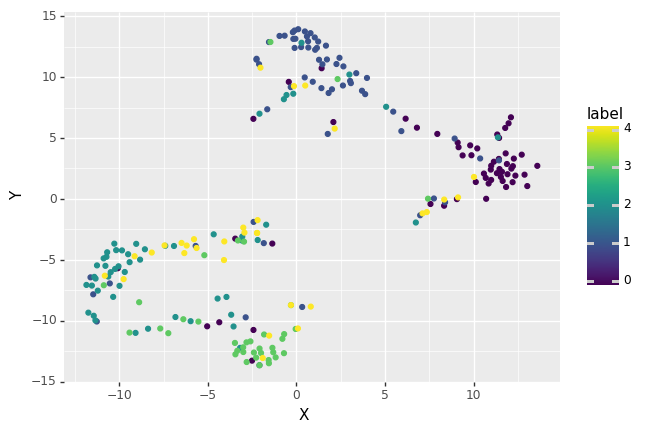

<ggplot: (8771432323017)>

======== Epoch 16 / 50 ========
Training...
Train loss: 0.04418197646737099
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6666666666666666
Validation Accuracy: 0.671875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7053571428571429
Validation Accuracy: 0.7109375
Validation Accuracy: 0.7152777777777778
Validation Accuracy: 0.73125
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Train loss: 0.0626667719334364
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6666666666666666
Validation Accuracy: 0.671875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7083333333333334
Validation Accuracy: 0.7232142857142857
Validation Accuracy: 0.7265625
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.74375
Validation Accuracy: 0.7613636363636364
Validation Accuracy: 0.6979166666666666
Train loss: 0.048263328770796456
Validation Accuracy: 0.75
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


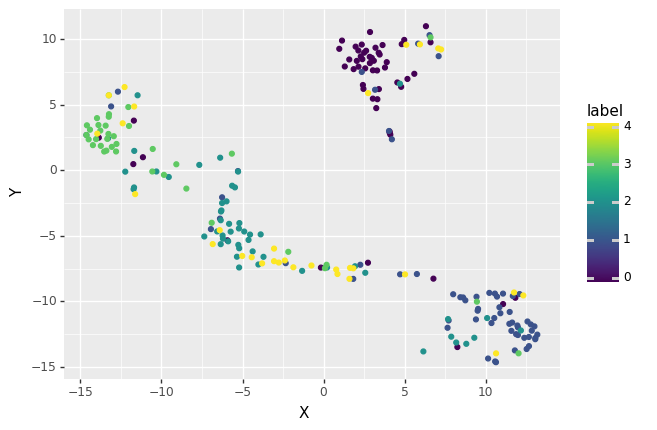

<ggplot: (8771432307089)>

======== Epoch 17 / 50 ========
Training...
Train loss: 0.004940472077578306
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.003408331423997879
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.008159874627987543
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validati

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


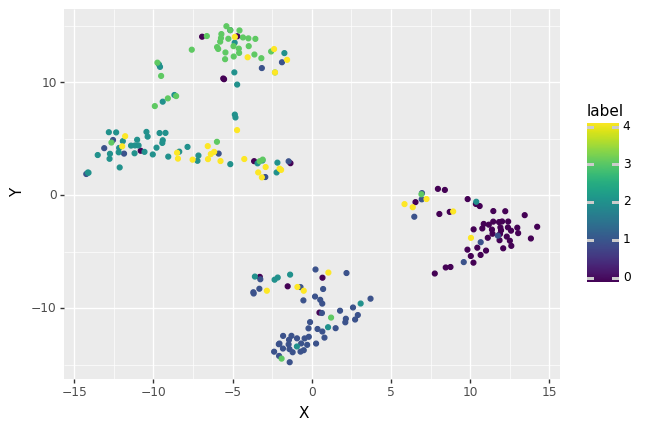

<ggplot: (8771432212205)>

======== Epoch 18 / 50 ========
Training...
Train loss: 0.05718233436346054
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.6979166666666666
Validation Accuracy: 0.7232142857142857
Validation Accuracy: 0.7265625
Validation Accuracy: 0.7361111111111112
Validation Accuracy: 0.74375
Validation Accuracy: 0.7613636363636364
Validation Accuracy: 0.6979166666666666
Train loss: 0.02991564222611487
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.6979166666666666
Validation Accuracy: 0.7232142857142857
Validation Accuracy: 0.7265625
Validation Accuracy: 0.7361111111111112
Validation Accuracy: 0.75
Validation Accuracy: 0.7670454545454546
Validation Accuracy: 0.703125
Train loss: 0.03952738409861922
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Va

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


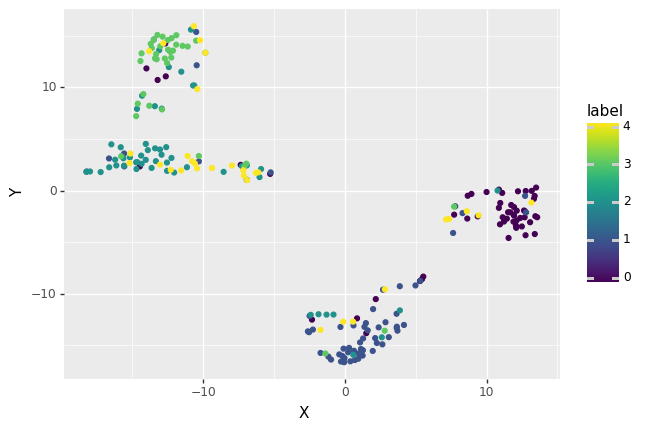

<ggplot: (8771432245365)>

======== Epoch 19 / 50 ========
Training...
Train loss: 0.005544427782297134
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.003874756395816803
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.7410714285714286
Validation Accuracy: 0.7421875
Validation Accuracy: 0.75
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.003256375901401043
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


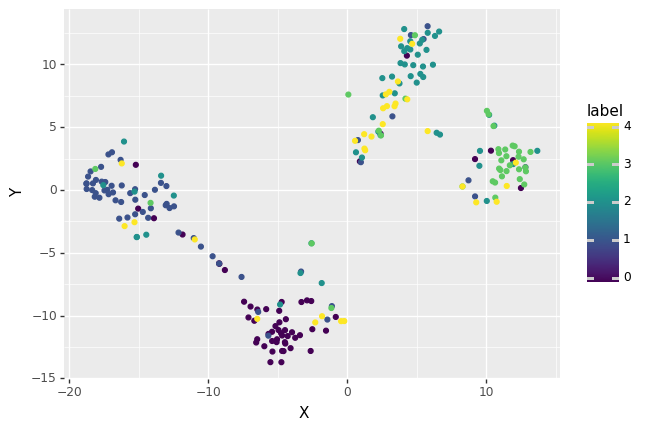

<ggplot: (8771432774525)>

======== Epoch 20 / 50 ========
Training...
Train loss: 0.0033637303858995438
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.7410714285714286
Validation Accuracy: 0.7421875
Validation Accuracy: 0.75
Validation Accuracy: 0.75625
Validation Accuracy: 0.7727272727272727
Validation Accuracy: 0.7083333333333334
Train loss: 0.025787307880818844
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.7410714285714286
Validation Accuracy: 0.7421875
Validation Accuracy: 0.75
Validation Accuracy: 0.75625
Validation Accuracy: 0.7727272727272727
Validation Accuracy: 0.7083333333333334
Train loss: 0.03549712337553501
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Vali

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


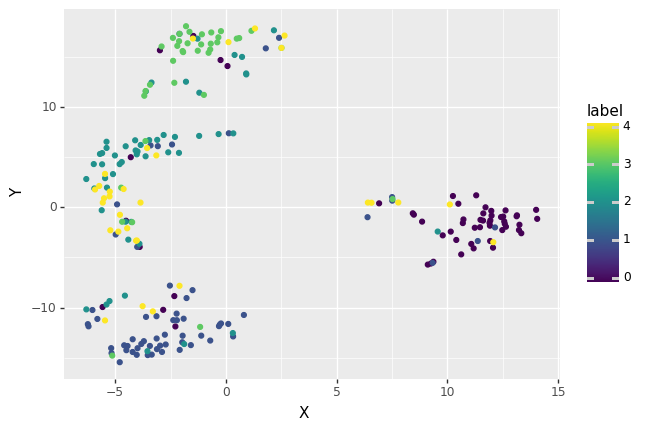

<ggplot: (8771432183341)>

======== Epoch 21 / 50 ========
Training...
Train loss: 0.0712965652346611
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.7083333333333334
Validation Accuracy: 0.7321428571428571
Validation Accuracy: 0.734375
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.75625
Validation Accuracy: 0.7727272727272727
Validation Accuracy: 0.7083333333333334
Train loss: 0.05421089194715023
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.7083333333333334
Validation Accuracy: 0.7321428571428571
Validation Accuracy: 0.734375
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.75625
Validation Accuracy: 0.7727272727272727
Validation Accuracy: 0.7083333333333334
Train loss: 0.036624907438332834
Validation Accuracy: 0.75
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


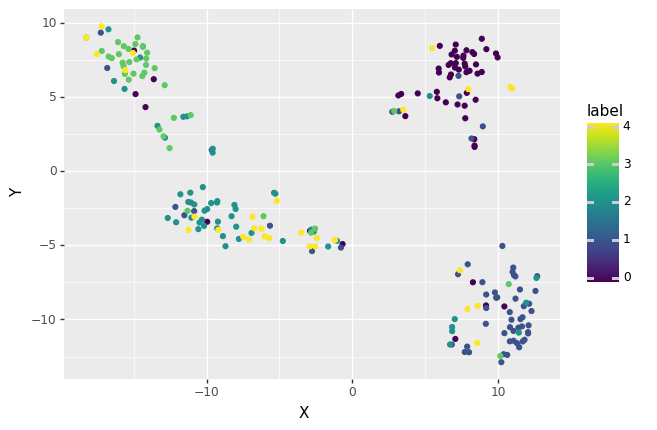

<ggplot: (8771432824809)>

======== Epoch 22 / 50 ========
Training...
Train loss: 0.0046049258671700954
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.7083333333333334
Validation Accuracy: 0.7321428571428571
Validation Accuracy: 0.734375
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.75625
Validation Accuracy: 0.7727272727272727
Validation Accuracy: 0.7083333333333334
Train loss: 0.003160225984174758
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.7083333333333334
Validation Accuracy: 0.7321428571428571
Validation Accuracy: 0.734375
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.75625
Validation Accuracy: 0.7727272727272727
Validation Accuracy: 0.7083333333333334
Train loss: 0.01863383676391095
Validation Accuracy: 0.75
Validation Accur

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


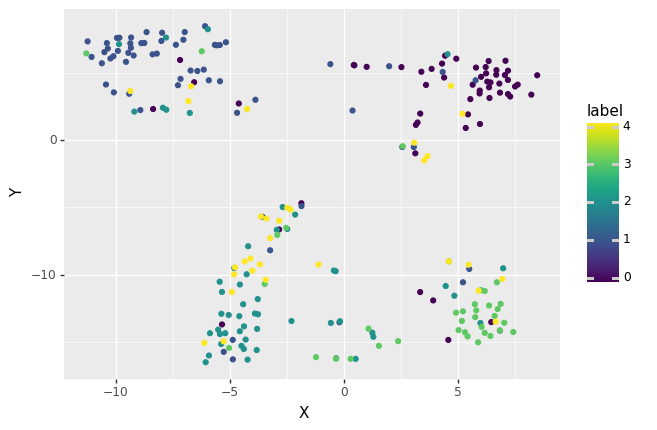

<ggplot: (8771432185129)>

======== Epoch 23 / 50 ========
Training...
Train loss: 0.0051472908817231655
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.75625
Validation Accuracy: 0.7727272727272727
Validation Accuracy: 0.7083333333333334
Train loss: 0.0033994049299508333
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.71875
Validation Accuracy: 0.7410714285714286
Validation Accuracy: 0.7421875
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7670454545454546
Validation Accuracy: 0.703125
Train loss: 0.002834735787473619
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Ac

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


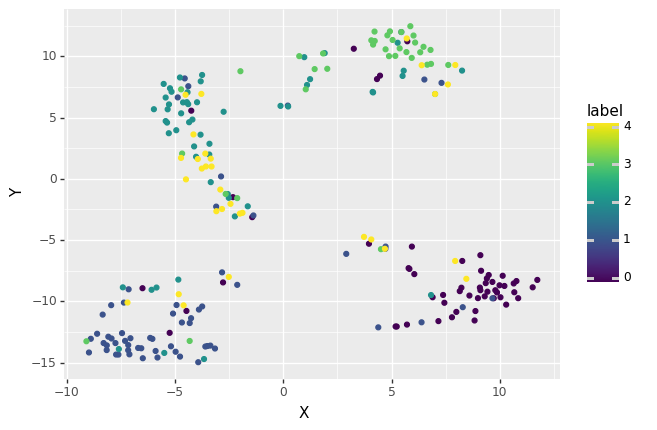

<ggplot: (8771432336033)>

======== Epoch 24 / 50 ========
Training...
Train loss: 0.004803505260497332
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.7410714285714286
Validation Accuracy: 0.7421875
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7670454545454546
Validation Accuracy: 0.703125
Train loss: 0.0030419931863434613
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.7410714285714286
Validation Accuracy: 0.7421875
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7670454545454546
Validation Accuracy: 0.703125
Train loss: 0.005774809862487018
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


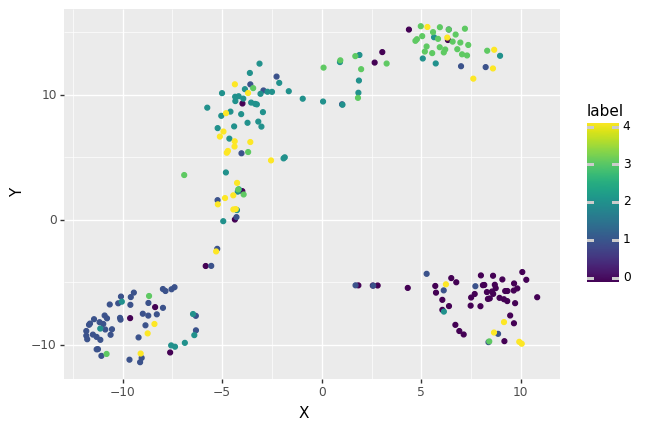

<ggplot: (8771432600021)>

======== Epoch 25 / 50 ========
Training...
Train loss: 0.006658878177404404
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.003920019080396742
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.0030373784247785807
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validat

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


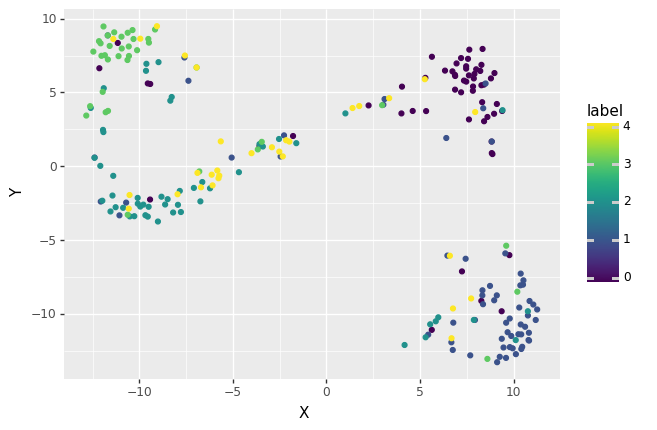

<ggplot: (8771432824653)>

======== Epoch 26 / 50 ========
Training...
Train loss: 0.036778777837753296
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.71875
Validation Accuracy: 0.7410714285714286
Validation Accuracy: 0.7421875
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.75
Validation Accuracy: 0.7670454545454546
Validation Accuracy: 0.703125
Train loss: 0.01900499314069748
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.71875
Validation Accuracy: 0.7410714285714286
Validation Accuracy: 0.7421875
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.75
Validation Accuracy: 0.7670454545454546
Validation Accuracy: 0.703125
Train loss: 0.013048165322591862
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validat

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


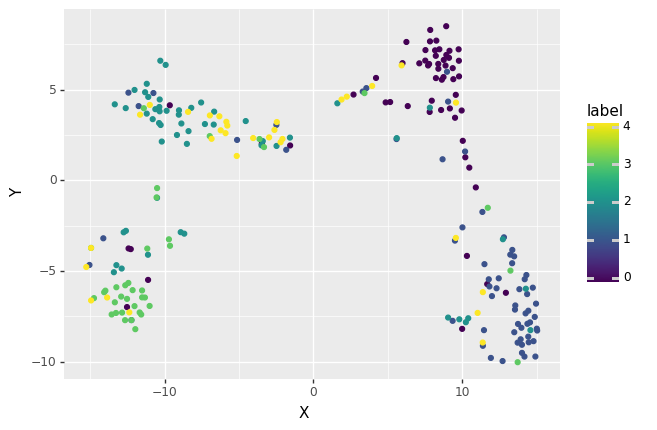

<ggplot: (8771432601429)>

======== Epoch 27 / 50 ========
Training...
Train loss: 0.004806001670658588
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.75625
Validation Accuracy: 0.7727272727272727
Validation Accuracy: 0.7083333333333334
Train loss: 0.041582482401281595
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.75625
Validation Accuracy: 0.7727272727272727
Validation Accuracy: 0.7083333333333334
Train loss: 0.043915494345128536
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


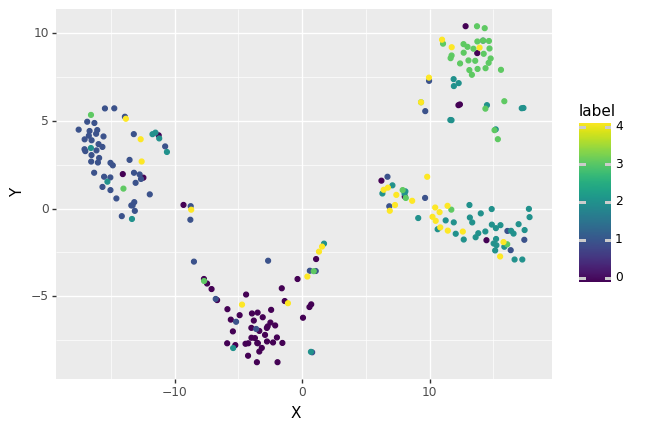

<ggplot: (8771432452585)>

======== Epoch 28 / 50 ========
Training...
Train loss: 0.07224813103675842
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6666666666666666
Validation Accuracy: 0.671875
Validation Accuracy: 0.6875
Validation Accuracy: 0.71875
Validation Accuracy: 0.7321428571428571
Validation Accuracy: 0.734375
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.74375
Validation Accuracy: 0.7613636363636364
Validation Accuracy: 0.6979166666666666
Train loss: 0.07231365516781807
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6666666666666666
Validation Accuracy: 0.671875
Validation Accuracy: 0.6875
Validation Accuracy: 0.71875
Validation Accuracy: 0.7321428571428571
Validation Accuracy: 0.734375
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.74375
Validation Accuracy: 0.7613636363636364
Validation Accuracy: 0.6979166666666666
Train loss: 0.04856889341802647
Validation Accuracy: 0.75
Validat

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


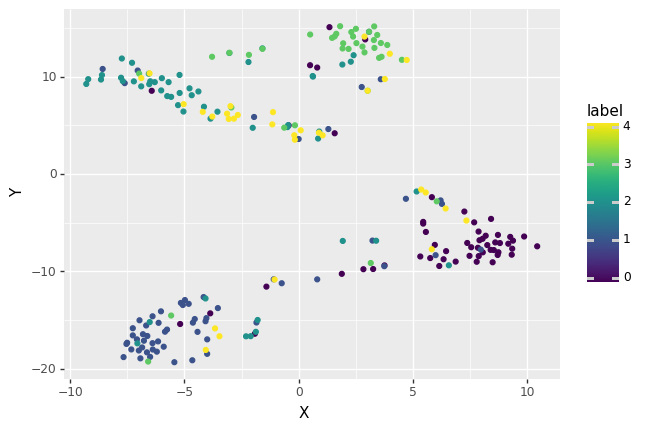

<ggplot: (8771432207709)>

======== Epoch 29 / 50 ========
Training...
Train loss: 0.1317424327135086
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.0882877316325903
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.05918772654452672
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


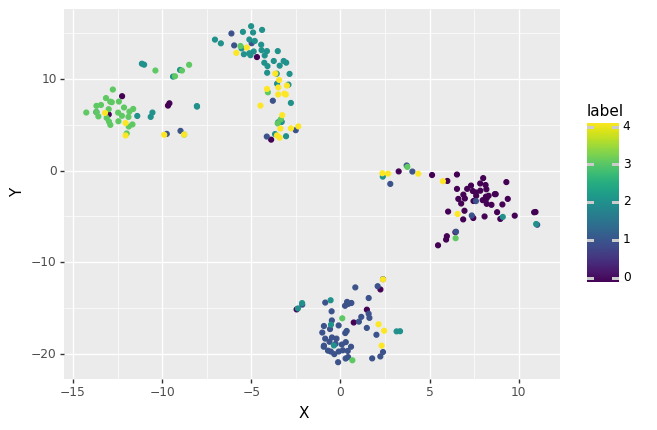

<ggplot: (8771432302249)>

======== Epoch 30 / 50 ========
Training...
Train loss: 0.0018027359619736671
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.01552710821852088
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.010659820361373326
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validati

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


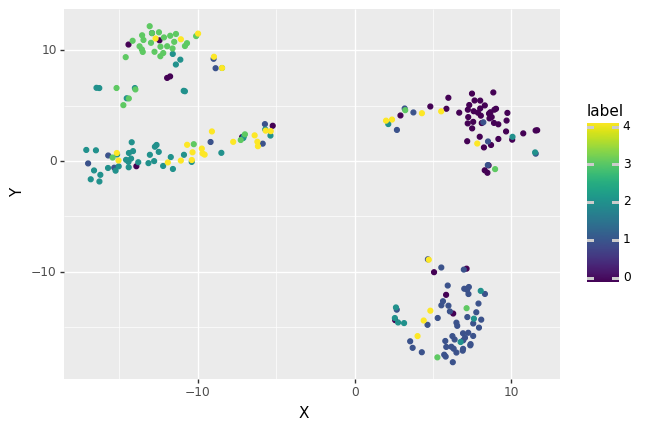

<ggplot: (8771432830565)>

======== Epoch 31 / 50 ========
Training...
Train loss: 0.11532396078109741
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.07552436366677284
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.059507823238770165
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


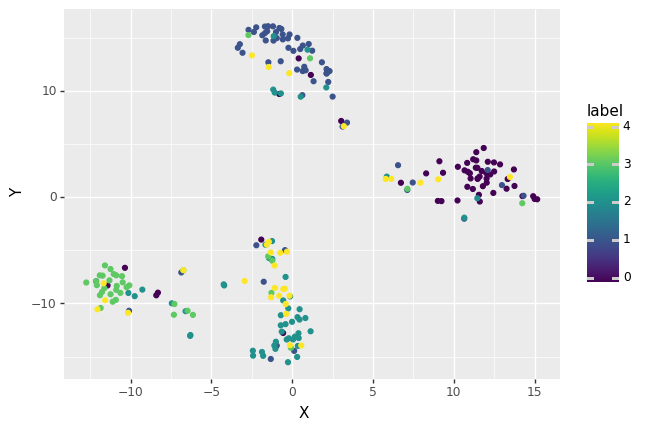

<ggplot: (8771432679757)>

======== Epoch 32 / 50 ========
Training...
Train loss: 0.0018764472333714366
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6666666666666666
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.71875
Validation Accuracy: 0.7321428571428571
Validation Accuracy: 0.734375
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.75
Validation Accuracy: 0.7670454545454546
Validation Accuracy: 0.703125
Train loss: 0.0013795464183203876
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6666666666666666
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.71875
Validation Accuracy: 0.7321428571428571
Validation Accuracy: 0.734375
Validation Accuracy: 0.7430555555555556
Validation Accuracy: 0.75
Validation Accuracy: 0.7670454545454546
Validation Accuracy: 0.703125
Train loss: 0.04048137409457316
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


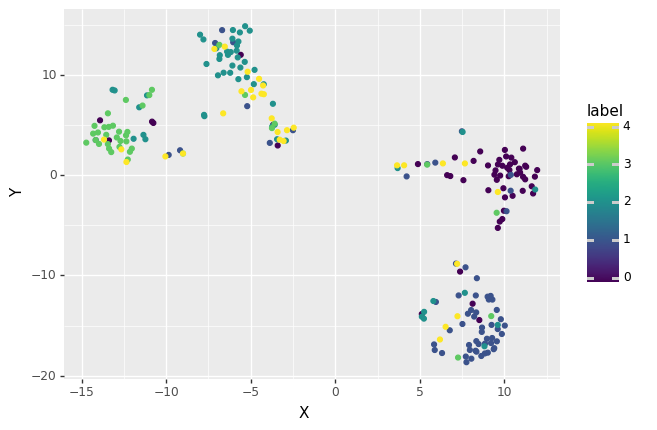

<ggplot: (8771432650541)>

======== Epoch 33 / 50 ========
Training...
Train loss: 0.0022742729634046555
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.0015235309838317335
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.012729611829854548
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Acc

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


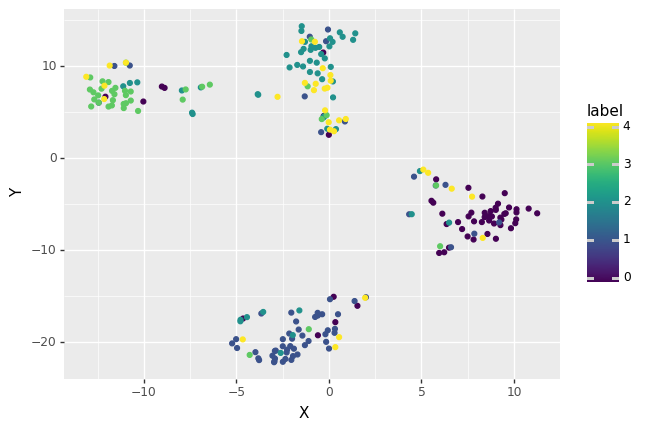

<ggplot: (8771432183341)>

======== Epoch 34 / 50 ========
Training...
Train loss: 0.1330227106809616
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.07563626579940319
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.7410714285714286
Validation Accuracy: 0.7421875
Validation Accuracy: 0.75
Validation Accuracy: 0.75625
Validation Accuracy: 0.7727272727272727
Validation Accuracy: 0.7083333333333334
Train loss: 0.06923232848445575
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


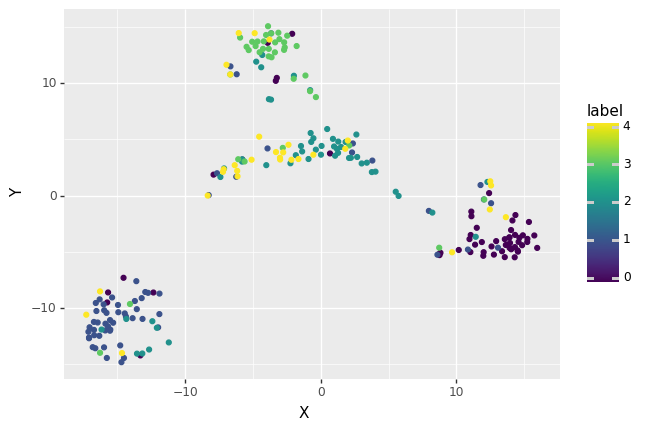

<ggplot: (8771432158761)>

======== Epoch 35 / 50 ========
Training...
Train loss: 0.002162597607821226
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.0015062251186463982
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.00127008338070785
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accur

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


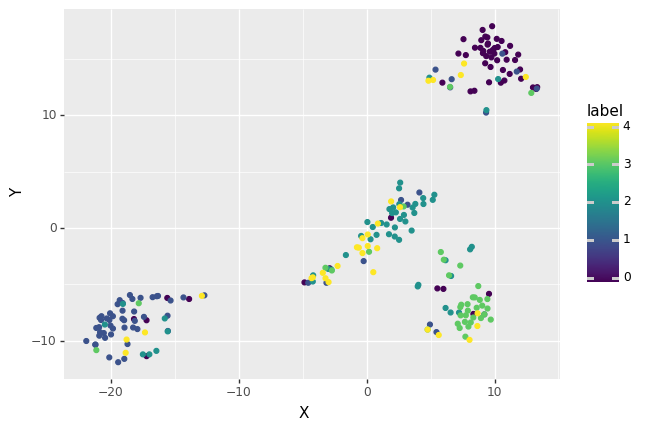

<ggplot: (8771432079465)>

======== Epoch 36 / 50 ========
Training...
Train loss: 0.03335651010274887
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.025825057178735733
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.017514782763707142
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accura

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


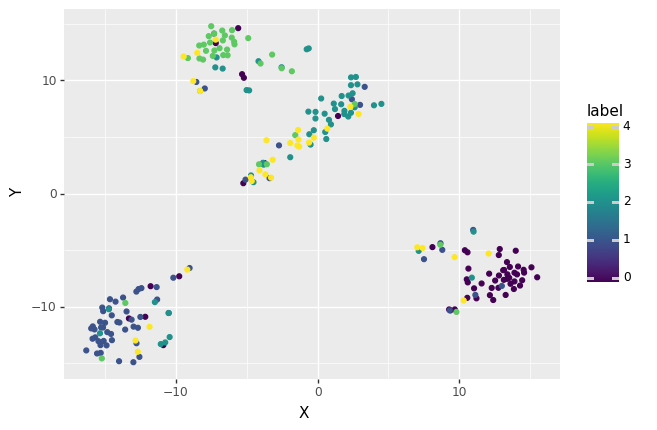

<ggplot: (8771432165161)>

======== Epoch 37 / 50 ========
Training...
Train loss: 0.0024459189735352993
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.04328993591479957
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.02912123268470168
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accura

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


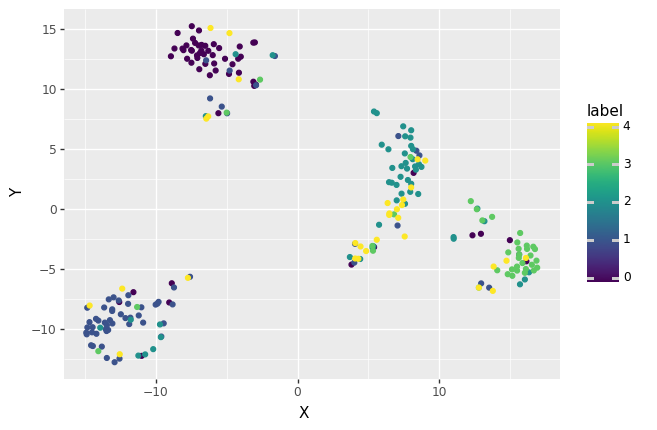

<ggplot: (8771432145729)>

======== Epoch 38 / 50 ========
Training...
Train loss: 0.00157065293751657
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.0011968416802119464
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.028417124703992158
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accur

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


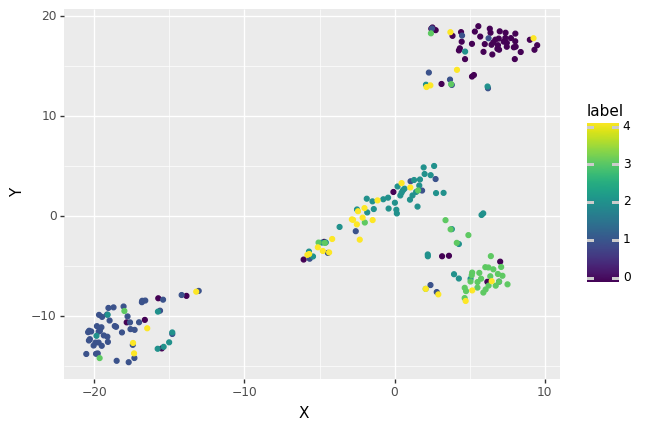

<ggplot: (8771432052077)>

======== Epoch 39 / 50 ========
Training...
Train loss: 0.04471859708428383
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.02280227211304009
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.0155055330057318
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Va

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


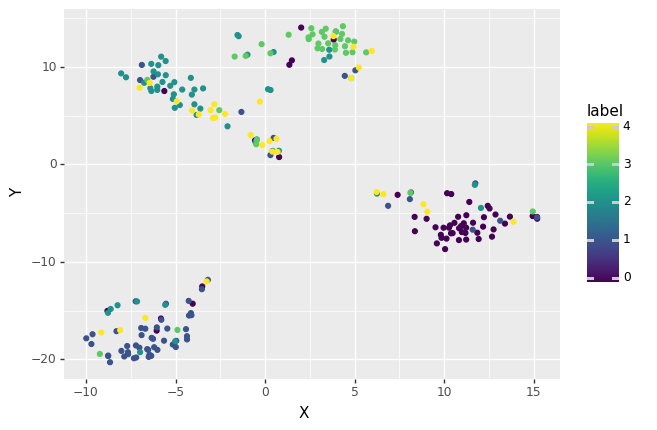

<ggplot: (8771432052081)>

======== Epoch 40 / 50 ========
Training...
Train loss: 0.001515143783763051
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.0011658768344204873
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.000994005143487205
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accu

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


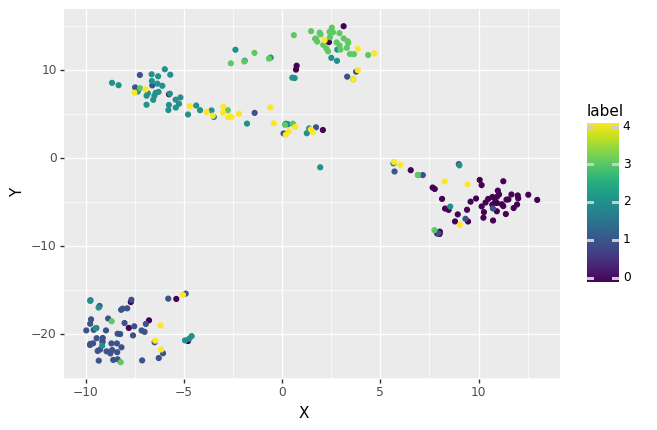

<ggplot: (8771432251757)>

======== Epoch 41 / 50 ========
Training...
Train loss: 0.0016539760399609804
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.7
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.7410714285714286
Validation Accuracy: 0.7421875
Validation Accuracy: 0.75
Validation Accuracy: 0.75625
Validation Accuracy: 0.7727272727272727
Validation Accuracy: 0.7083333333333334
Train loss: 0.024307347484864295
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.05188298450472454
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accu

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


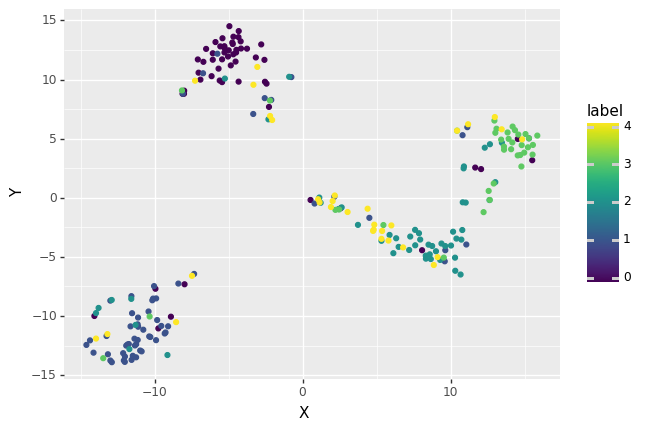

<ggplot: (8771431978101)>

======== Epoch 42 / 50 ========
Training...
Train loss: 0.056944359093904495
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.07846013642847538
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.05252866167575121
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


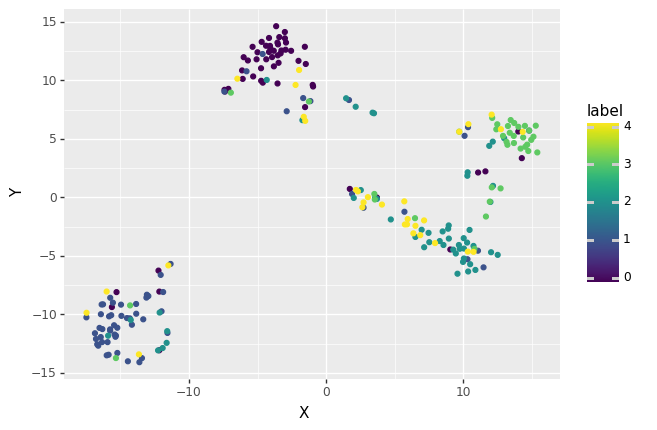

<ggplot: (8771431839001)>

======== Epoch 43 / 50 ========
Training...
Train loss: 0.001143230008892715
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.04151299496879801
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.04956536177390566
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


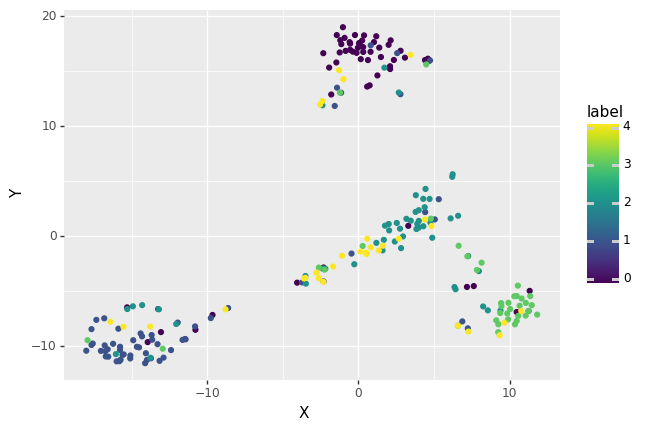

<ggplot: (8771431818121)>

======== Epoch 44 / 50 ========
Training...
Train loss: 0.24712322652339935
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.12393526901723817
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.08285279752453789
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


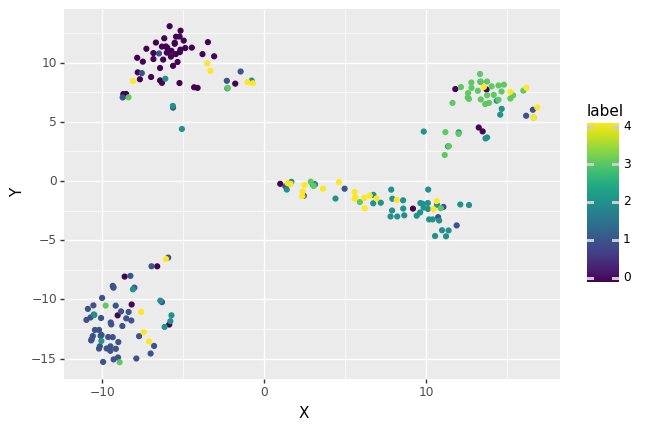

<ggplot: (8771432237593)>

======== Epoch 45 / 50 ========
Training...
Train loss: 0.001456709229387343
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.008576357562560588
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.00595300206138442
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accura

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


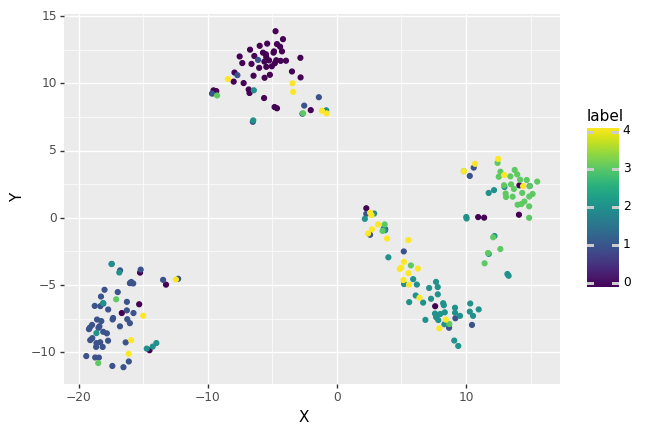

<ggplot: (8771431739641)>

======== Epoch 46 / 50 ========
Training...
Train loss: 0.0013515595346689224
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.0010160670499317348
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.0009024710937713584
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Valid

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


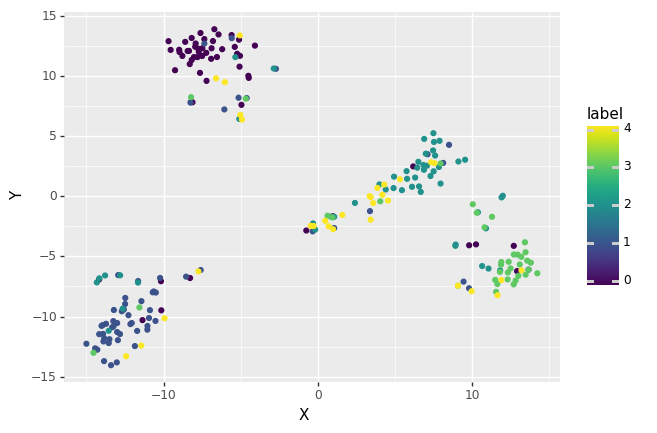

<ggplot: (8771431695957)>

======== Epoch 47 / 50 ========
Training...
Train loss: 0.0011205850169062614
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.7625
Validation Accuracy: 0.7784090909090909
Validation Accuracy: 0.7135416666666666
Train loss: 0.0518451570533216
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.039512994699180126
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


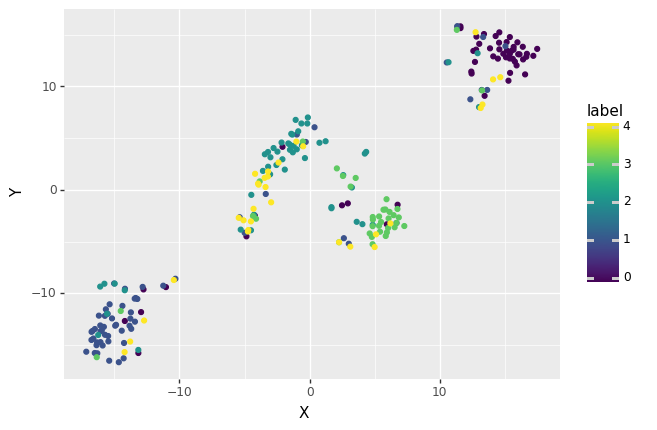

<ggplot: (8771431818225)>

======== Epoch 48 / 50 ========
Training...
Train loss: 0.05831608921289444
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.029480774566764012
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.019889093469828367
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validatio

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


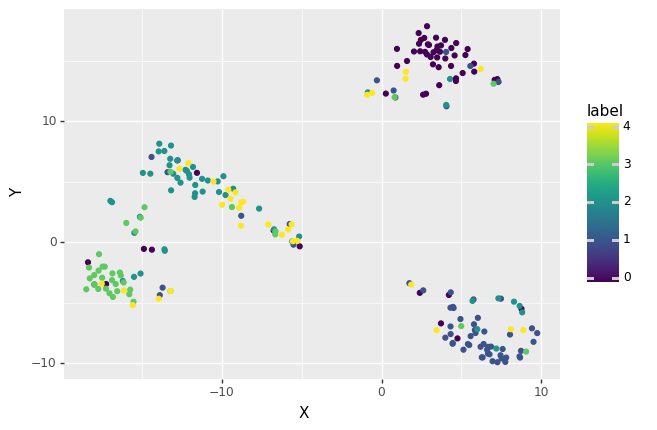

<ggplot: (8771431638465)>

======== Epoch 49 / 50 ========
Training...
Train loss: 0.004090168047696352
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.07639170833863318
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation Accuracy: 0.703125
Validation Accuracy: 0.7125
Validation Accuracy: 0.7395833333333334
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7569444444444444
Validation Accuracy: 0.76875
Validation Accuracy: 0.7840909090909091
Validation Accuracy: 0.71875
Train loss: 0.05114536026182274
Validation Accuracy: 0.75
Validation Accuracy: 0.6875
Validation Accuracy: 0.6875
Validation

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



  Network visualization  


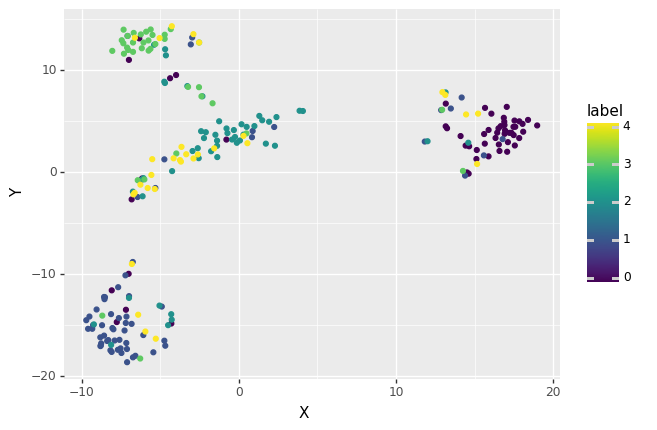

<ggplot: (8771432509349)>

Training complete!

Final result is below!
{'epoch1': {'Total': 0.506, 'Loss': 1.36, 'Tar': 0.66, 'Int': 0.869, 'Rep': 0.281, 'Var': 0.351, 'Tec': 0.0}, 'epoch2': {'Total': 0.557, 'Loss': 1.013, 'Tar': 0.802, 'Int': 0.76, 'Rep': 0.332, 'Var': 0.569, 'Tec': 0.0}, 'epoch3': {'Total': 0.614, 'Loss': 0.736, 'Tar': 0.796, 'Int': 0.746, 'Rep': 0.641, 'Var': 0.736, 'Tec': 0.0}, 'epoch4': {'Total': 0.619, 'Loss': 0.487, 'Tar': 0.838, 'Int': 0.643, 'Rep': 0.766, 'Var': 0.499, 'Tec': 0.022}, 'epoch5': {'Total': 0.653, 'Loss': 0.311, 'Tar': 0.878, 'Int': 0.65, 'Rep': 0.586, 'Var': 0.534, 'Tec': 0.222}, 'epoch6': {'Total': 0.662, 'Loss': 0.187, 'Tar': 0.708, 'Int': 0.709, 'Rep': 0.745, 'Var': 0.634, 'Tec': 0.217}, 'epoch7': {'Total': 0.662, 'Loss': 0.117, 'Tar': 0.727, 'Int': 0.595, 'Rep': 0.703, 'Var': 0.618, 'Tec': 0.213}, 'epoch8': {'Total': 0.661, 'Loss': 0.109, 'Tar': 0.776, 'Int': 0.747, 'Rep': 0.678, 'Var': 0.589, 'Tec': 0.294}, 'epoch9': {'Total': 0.67, 'Loss': 0

In [23]:
      # RandomSeed
      seed_val = setSeed
      random.seed(seed_val)
      np.random.seed(seed_val)
      torch.manual_seed(seed_val)
      torch.cuda.manual_seed_all(seed_val)

      # Gradient Initialize
      model.zero_grad()

      final_info = {}

      f = open("/result.txt", 'w')
      f.write("epoch,sentence,originallabel,predictedlabel,predictedFunction,result"+"\n")

      # Repeat as Epoch
      for epoch_i in range(1, epochs):
          
          # ========================================
          #               Training
          # ========================================
          
          print("")
          print('======== Epoch {:} / {:} ========'.format(epoch_i, epochs))
          print('Training...')

          # Set Start Time
          t0 = time.time()

          # Loss Initialize
          total_loss = 0

          # Change to Train Mode
          model.train()

          # Tracking variables
          tr_loss = 0
          nb_tr_examples, nb_tr_steps = 0, 0
              
          # Import repeatedly by batch from the data loader
          for step, batch in enumerate(train_dataloader):
              # Display Progress Information
              if step % 500 == 0 and not step == 0:
                  elapsed = format_time(time.time() - t0)
                  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

              # Batch GPU
              batch = tuple(t.to(device) for t in batch)
              
              # Extract data from batches
              b_input_ids, b_input_mask, b_labels = batch

              # Forward                 
              outputs = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask, 
                              labels=b_labels)
              
              # Get Loss
              loss = outputs[0]
             
              # Total Loss Calculate
              total_loss += loss.item()

              # Calculate gradients by performing Backward
              loss.backward()

              # Gradient Clipping
              torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

              # Update weight parameters via gradient
              optimizer.step()

              # Less Learning with Scheduler
              scheduler.step()

              # Update tracking variables
              tr_loss += loss.item()
              nb_tr_examples += b_input_ids.size(0)
              nb_tr_steps += 1

              print("Train loss: {}".format(tr_loss/nb_tr_steps))

              # Validation

              # Put model in evaluation mode to evaluate loss on the validation set
              model.eval()

              # Tracking variables 
              eval_loss, eval_accuracy = 0, 0
              nb_eval_steps, nb_eval_examples = 0, 0

              # Evaluate data for one epoch
              for batch in validation_dataloader:
                # Add batch to GPU
                batch = tuple(t.to(device) for t in batch)
                # Unpack the inputs from our dataloader
                b_input_ids, b_input_mask, b_labels = batch
                # Telling the model not to compute or store gradients, saving memory and speeding up validation
                with torch.no_grad():
                  # Forward pass, calculate logit predictions
                  logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
                # Move logits and labels to CPU
                logits = logits['logits'].detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
                eval_accuracy += tmp_eval_accuracy
                nb_eval_steps += 1

                print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

              # Gradient Initialization
              model.zero_grad()

          # Calculate Avg_loss
          avg_train_loss = total_loss / len(train_dataloader)            

          print("")
          print("  Average training loss: {0:.2f}".format(avg_train_loss))
          print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
              
          # ========================================
          #               Validation
          # ========================================

          print("")
          print("Running Validation...")

          # Set Start Time
          t0 = time.time()

          # Change to Validation Mode
          model.eval()

          # Variable Initialization
          eval_loss, eval_accuracy = 0, 0
          nb_eval_steps, nb_eval_examples = 0, 0
          FNS_nb_eval_steps, FNS_eval_accuracy = 0, 0
          INS_nb_eval_steps, INS_eval_accuracy = 0, 0
          DIR_nb_eval_steps, DIR_eval_accuracy = 0, 0
          EFF_nb_eval_steps, EFF_eval_accuracy = 0, 0
          CRT_nb_eval_steps, CRT_eval_accuracy = 0, 0


          epoch_info = {}

          # Import repeatedly by batch from the data loader
          for batch in test_dataloader:
              # Batch GPU
              batch = tuple(t.to(device) for t in batch)
              
              # Extract data from batches
              b_input_ids, b_input_mask, b_labels = batch              
              
              with torch.no_grad():     
                  
                  outputs = model(b_input_ids, 
                                  token_type_ids=None, 
                                  attention_mask=b_input_mask)
              
              # Get logit
              logits = outputs[0]

              # Move data to CPU
              logits = logits.detach().cpu().numpy()
              label_ids = b_labels.to('cpu').numpy()
              
              # Calculate accuracy by comparing output logits and labels
              tmp_eval_accuracy = flat_accuracy(logits, label_ids)
              eval_accuracy += tmp_eval_accuracy
              nb_eval_steps += 1

              FNS_tmp_eval_accuracy = TAR_flat_accuracy(logits, label_ids)
              FNS_eval_accuracy += FNS_tmp_eval_accuracy
              FNS_nb_eval_steps += 1

              INS_tmp_eval_accuracy = INT_flat_accuracy(logits, label_ids)
              INS_eval_accuracy += INS_tmp_eval_accuracy
              INS_nb_eval_steps += 1

              DIR_tmp_eval_accuracy = REP_flat_accuracy(logits, label_ids)
              DIR_eval_accuracy += DIR_tmp_eval_accuracy
              DIR_nb_eval_steps += 1

              EFF_tmp_eval_accuracy = VAR_flat_accuracy(logits, label_ids)
              EFF_eval_accuracy += EFF_tmp_eval_accuracy
              EFF_nb_eval_steps += 1

              CRT_tmp_eval_accuracy = TEC_flat_accuracy(logits, label_ids)
              CRT_eval_accuracy += CRT_tmp_eval_accuracy
              CRT_nb_eval_steps += 1

          print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
          print("  Validation took: {:}".format(format_time(time.time() - t0)))
          print("")
          print("  Detail accuracy  ")
          print("  Target_Accuracy: {0:.2f}".format(FNS_eval_accuracy/FNS_nb_eval_steps))
          print("  Intermediation_Accuracy: {0:.2f}".format(INS_eval_accuracy/INS_nb_eval_steps))
          print("  Representation_Accuracy: {0:.2f}".format(DIR_eval_accuracy/DIR_nb_eval_steps))
          print("  Visual_Variables_Accuracy: {0:.2f}".format(EFF_eval_accuracy/EFF_nb_eval_steps))
          print("  Visual_Techniques_Accuracy: {0:.2f}".format(CRT_eval_accuracy/CRT_nb_eval_steps))

          epoch_info["Total"] = round(eval_accuracy/nb_eval_steps,3)
          epoch_info["Loss"] = round(avg_train_loss,3)
          epoch_info["Tar"] = round(FNS_eval_accuracy/FNS_nb_eval_steps,3)
          epoch_info["Int"] = round(INS_eval_accuracy/INS_nb_eval_steps,3)
          epoch_info["Rep"] = round(DIR_eval_accuracy/DIR_nb_eval_steps,3)
          epoch_info["Var"] = round(EFF_eval_accuracy/EFF_nb_eval_steps,3)
          epoch_info["Tec"] = round(CRT_eval_accuracy/CRT_nb_eval_steps,3)

          final_info["epoch"+str(epoch_i)] = epoch_info


          # Change to evaluate mode
          model.eval()
          test_input_ids = []
          test_input_mask = []
          test_labels = []

          num = 0
          for step, batch in enumerate(test_data):   #467, 128
            # print("batch",batch)
          
            batch = tuple(t.to(device) for t in batch)
            
            b_input_ids, b_input_mask, b_labels = batch
            input_ids_arr = []
            input_mask_arr = []

            

            for i in range(0,len(b_input_ids)):
              input_ids_arr.append(int(b_input_ids[i]))
              input_mask_arr.append(int(b_input_mask[i]))

            
            test_input_ids.append(input_ids_arr)
            test_input_mask.append(input_mask_arr)
            test_labels.append(int(b_labels))


          test_input_ids = torch.tensor(test_input_ids)
          test_input_mask = torch.tensor(test_input_mask)
          test_labels = test_labels

          test_input_ids = test_input_ids.to(device)
          test_input_mask = test_input_mask.to(device)


          # No calculate gradient
          with torch.no_grad():     
              # Do Forward
              outputs = model(test_input_ids, 
                              token_type_ids=None, 
                              attention_mask=test_input_mask)
              

          sentence_vecs_sum = outputs[0]

          sentence_array = []
          for i in range(0,len(sentence_vecs_sum)):
            each_array = []
            for j in range(0,len(sentence_vecs_sum[i])):
              each_array.append(float(sentence_vecs_sum[i][j]))
            sentence_array.append(each_array)

          initial_df = pd.DataFrame(sentence_array)

          from sklearn.manifold import TSNE
          tsne = TSNE(n_components=2, random_state=0)
          tsne_obj= tsne.fit_transform(initial_df)

          tsne_df = pd.DataFrame({'X':tsne_obj[:,0],'Y':tsne_obj[:,1],'label':test_labels})

          # f = open("/content/drive/MyDrive/"+postposition+"/Outcomes/"+postposition+"_accuracy_trial_"+str(currentTry)+"_epoch_"+str(epochs)+".txt", 'w')
          # tsne_df.to_csv("/content/drive/MyDrive/"+postposition+"_accuracy_trial_"+str(currentTry)+"_epoch_"+str(epochs)+".csv")
          # f = open(""+postposition+"/Outcomes/"+postposition+"_accuracy_trial_"+str(currentTry)+"_epoch_"+str(epochs)+".txt", 'w')
          # f.write("epoch,sentence,originallabel,predictedlabel,predictedFunction,result"+"\n")

          import numpy as np   
          import pandas as pd 
          from plotnine import *
          import matplotlib.pyplot as plt

          print("")
          print("  Network visualization  ")
          print(ggplot(tsne_df, aes(x='X', y='Y')) + geom_point(aes(colour = 'label')))

         

      print("")
      print("Training complete!")
      print("")
      print("Final result is below!")
      print(final_info)

      # f.close()

In [24]:
#Set Start Time
t0 = time.time()

# Change to evaluate mode
model.eval()

# Variable Initialize
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Import repeatedly by batch from the data loader
for step, batch in enumerate(test_dataloader):  #15
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch

    
    with torch.no_grad():     
      
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
        
    
    logits = outputs[0]  #32 , 8

    
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
   
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.66
Test took: 0:00:01


In [25]:
#@title Create functions

In [26]:
def compute_metrics(eval_preds):
    metric = load_metric("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
  
    return metric.compute(predictions=predictions, references=labels)

In [27]:
# Convert Input Data
def convert_input_data(sentences):

      # BERT Tokenize
      tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

      # Max Length
      MAX_LEN = setMaxLength

      # Token to numeric index
      input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
      
      # Cut the sentence to MAX_LEN length and fill the missing part with padding 0
      input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

      # Attention Mask Initialize
      attention_masks = []

      # Set the attention mask to 1 if it's not padding and 0 if it's padding
      # The padding part does not perform attention on the BERT model, which speeds up
      for seq in input_ids:
          seq_mask = [float(i>0) for i in seq]
          attention_masks.append(seq_mask)

      # Convert data to tensors in the pytorch
      inputs = torch.tensor(input_ids)
      masks = torch.tensor(attention_masks)

      return inputs, masks

In [28]:
# Test Sentence
def test_sentences(sentences):

    # Change to evaluate mode
    model.eval()

    # Convert a sentence to input data
    inputs, masks = convert_input_data(sentences)

    # Input Data to GPU
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)            
    
    with torch.no_grad():     
       
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # Get Lodd
    logits = outputs[0]

    # Input data to CPU
    logits = logits.detach().cpu().numpy()

    return logits

In [29]:
# Sentence Classify Test 
# 0: Target, 1: Intermediation, 2: Representation, 3: Vis_Var, 4: Vis_Tech

logits = test_sentences(['To make individual messages apparent and maintain the link between the message visual symbol and its text contents.',])
logits2 = test_sentences(['All the illustrations thus far have shown the messages as temporally ordered and the conversations as ordered by start time.'])

print(logits)
print(np.argmax(logits))

print(logits2)
print(np.argmax(logits2))

[[-1.1702329  6.8992205 -1.5707632 -1.4899464 -1.8187218]]
1
[[ 2.4053552  -0.27445868  0.10416691 -3.9452312   1.6770818 ]]
0
